In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Dense, MaxPool2D, LeakyReLU, Reshape, Dropout, Flatten, GaussianNoise, Embedding, multiply, concatenate, add
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import time

In [4]:
def normalize_img(img):
    return (img - 127.5)/127.5

def unnormalize_img(img):
    return (img + 1.) / 2.

In [5]:
train_imgs = []
train_classes = []
class_index = 0
import os
for root, dirs, files in os.walk("./CUB_200_2011/CUB_200_2011/images-cleaned/", topdown=False):
    print(f'{len(files)} samples in class {class_index}, ({root})')
    for name in files:
        train_imgs.append(cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_RGB2BGR))
        train_classes.append(class_index)
    class_index += 1
train_imgs = np.array(train_imgs)
train_imgs = (train_imgs - 127.5)/127.5
train_imgs = train_imgs.astype(np.float32)
train_classes = np.array(train_classes)

60 samples in class 0, (./CUB_200_2011/CUB_200_2011/images-cleaned/001.Black_footed_Albatross)
60 samples in class 1, (./CUB_200_2011/CUB_200_2011/images-cleaned/002.Laysan_Albatross)
58 samples in class 2, (./CUB_200_2011/CUB_200_2011/images-cleaned/003.Sooty_Albatross)
60 samples in class 3, (./CUB_200_2011/CUB_200_2011/images-cleaned/004.Groove_billed_Ani)
44 samples in class 4, (./CUB_200_2011/CUB_200_2011/images-cleaned/005.Crested_Auklet)
41 samples in class 5, (./CUB_200_2011/CUB_200_2011/images-cleaned/006.Least_Auklet)
53 samples in class 6, (./CUB_200_2011/CUB_200_2011/images-cleaned/007.Parakeet_Auklet)
48 samples in class 7, (./CUB_200_2011/CUB_200_2011/images-cleaned/008.Rhinoceros_Auklet)
59 samples in class 8, (./CUB_200_2011/CUB_200_2011/images-cleaned/009.Brewer_Blackbird)
60 samples in class 9, (./CUB_200_2011/CUB_200_2011/images-cleaned/010.Red_winged_Blackbird)
60 samples in class 10, (./CUB_200_2011/CUB_200_2011/images-cleaned/011.Rusty_Blackbird)
56 samples in cla

60 samples in class 94, (./CUB_200_2011/CUB_200_2011/images-cleaned/095.Baltimore_Oriole)
60 samples in class 95, (./CUB_200_2011/CUB_200_2011/images-cleaned/096.Hooded_Oriole)
59 samples in class 96, (./CUB_200_2011/CUB_200_2011/images-cleaned/097.Orchard_Oriole)
60 samples in class 97, (./CUB_200_2011/CUB_200_2011/images-cleaned/098.Scott_Oriole)
60 samples in class 98, (./CUB_200_2011/CUB_200_2011/images-cleaned/099.Ovenbird)
60 samples in class 99, (./CUB_200_2011/CUB_200_2011/images-cleaned/100.Brown_Pelican)
50 samples in class 100, (./CUB_200_2011/CUB_200_2011/images-cleaned/101.White_Pelican)
60 samples in class 101, (./CUB_200_2011/CUB_200_2011/images-cleaned/102.Western_Wood_Pewee)
60 samples in class 102, (./CUB_200_2011/CUB_200_2011/images-cleaned/103.Sayornis)
60 samples in class 103, (./CUB_200_2011/CUB_200_2011/images-cleaned/104.American_Pipit)
49 samples in class 104, (./CUB_200_2011/CUB_200_2011/images-cleaned/105.Whip_poor_Will)
60 samples in class 105, (./CUB_200_20

58 samples in class 189, (./CUB_200_2011/CUB_200_2011/images-cleaned/190.Red_cockaded_Woodpecker)
60 samples in class 190, (./CUB_200_2011/CUB_200_2011/images-cleaned/191.Red_headed_Woodpecker)
60 samples in class 191, (./CUB_200_2011/CUB_200_2011/images-cleaned/192.Downy_Woodpecker)
60 samples in class 192, (./CUB_200_2011/CUB_200_2011/images-cleaned/193.Bewick_Wren)
60 samples in class 193, (./CUB_200_2011/CUB_200_2011/images-cleaned/194.Cactus_Wren)
60 samples in class 194, (./CUB_200_2011/CUB_200_2011/images-cleaned/195.Carolina_Wren)
59 samples in class 195, (./CUB_200_2011/CUB_200_2011/images-cleaned/196.House_Wren)
60 samples in class 196, (./CUB_200_2011/CUB_200_2011/images-cleaned/197.Marsh_Wren)
60 samples in class 197, (./CUB_200_2011/CUB_200_2011/images-cleaned/198.Rock_Wren)
60 samples in class 198, (./CUB_200_2011/CUB_200_2011/images-cleaned/199.Winter_Wren)
60 samples in class 199, (./CUB_200_2011/CUB_200_2011/images-cleaned/200.Common_Yellowthroat)
0 samples in class 20

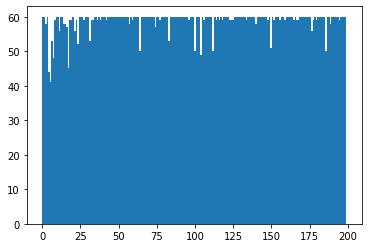

(11788, 64, 64, 3)


In [6]:
plt.hist(train_classes, bins=200)
plt.show()
assert(len(train_imgs) == len(train_classes))
print(train_imgs.shape)

In [7]:
def create_simple_attrs(attrs):
    # Structure is like so: [0-14:color, 15-19:size, 20-33:shape]

    simple_attrs = np.zeros((attrs.shape[0], 34))
    
    # Color
    simple_attrs[:, 0:15] = attrs[:, 248:263]
    
    # Size and shape
    simple_attrs[:, 15:34] = attrs[:, 217:236]
    
    return simple_attrs


In [8]:
def create_even_simpler_attrs(attrs):
    # Structure is like so: [0-4:color, 5-7:size, 8-9:shape]
    
    simplest_attrs = np.zeros((attrs.shape[0], 10))
    
    simplest_attrs[:, 0] = attrs[:, 1] # Brown
    simplest_attrs[:, 1] = attrs[:, 5] # Grey
    simplest_attrs[:, 2] = attrs[:, 11] # Black
    simplest_attrs[:, 3] = attrs[:, 12] # White
    simplest_attrs[:, 4] = np.clip(np.sum(attrs[:, [0, 2, 3, 4, 6, 7, 8, 9, 10, 13, 14]], axis=1), a_min=0, a_max=1) # Other
    
    simplest_attrs[:, 5] = attrs[:, 19] # Smallest
    simplest_attrs[:, 6] = attrs[:, 16] # Small
    simplest_attrs[:, 7] = np.clip(np.sum(attrs[:, [15, 17, 18]], axis=1), a_min=0, a_max=1) # Large
    
    simplest_attrs[:, 8] = attrs[:, 33] # Perching-like
    simplest_attrs[:, 9] = np.clip(np.sum(attrs[:, [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]], axis=1), a_min=0, a_max=1) # Not perching-like
    
    return simplest_attrs

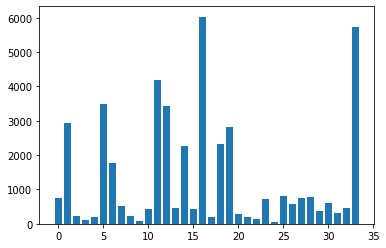

In [9]:
def load_image_attributes():
    train_attrs = np.zeros((train_imgs.shape[0], 312))
    with open('./CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt', 'r') as f:
        lines = f.readlines()
        for line in lines:
            
            # For now we don't care about attribute certainty, just if it is present.
            try:
                split = line.split()
                img_id = int(split[0])
                assert(img_id > 0)
                assert(img_id <= 11788)
                attr_id = int(split[1])
                assert(attr_id > 0)
                assert(attr_id <= 312)
                is_present = int(split[2])
                assert(is_present == 0 or is_present == 1)
            except: 
                print(line)
                print(line.split())
                return
            
            train_attrs[img_id-1, attr_id-1] = is_present
    return train_attrs

train_attrs = load_image_attributes().astype('float32')
train_attrs = create_simple_attrs(train_attrs)
plt.bar([x for x in range(34)], np.sum(train_attrs, axis=0))
plt.show()
# train_attrs = create_even_simpler_attrs(train_attrs)
train_attrs = train_attrs.astype(np.float32)

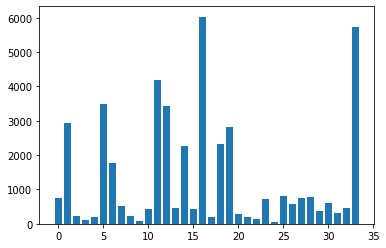

1312.9117
1604.2759


In [11]:
plt.bar([x for x in range(34)], np.sum(train_attrs, axis=0))
plt.show()
sum_attrs = np.sum(train_attrs, axis=0)

print(np.mean(sum_attrs))
print(np.std(sum_attrs))
# np.argmin(sum_attrs)

In [12]:
def make_generator_model(shape):
    
    noise_in = Input(shape=shape)
    attributes_in = Input(shape=(34,))
    
    input_layer = concatenate([noise_in, attributes_in])
    
    x = Dense(16*16*64*2)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((16, 16, 128))(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model([noise_in, attributes_in], x)

In [13]:
generator = make_generator_model((300,))
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 334)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32768)        10977280    concatenate[0][0]            

(34,)


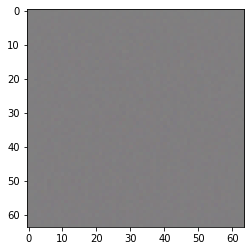

In [14]:
generator = make_generator_model((300,))

noise = np.random.normal(0, 1, 300)
label = train_attrs[0]
print(label.shape)

generated_image = generator.predict( [np.array([noise]), np.array([label])] )[0]
plt.imshow(unnormalize_img(generated_image), )

In [15]:
def make_valid_discriminator_model():
    input_layer = Input((64, 64, 3))
#     x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', name='valid')(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    
    x = Flatten()(x)
    x = Dense(64)(x) 
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    valid = Dense(1, activation='sigmoid')(x)
    
    return Model(input_layer, valid)

In [16]:
discriminator_valid = make_valid_discriminator_model()
discriminator_valid.summary()
valid = discriminator_valid.predict(np.array([generated_image]))


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
valid (Conv2D)               (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0   

In [83]:
def make_attr_discriminator_model():
    input_layer = Input((64, 64, 3))
    
#     x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', name='attr')(input_layer)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)

    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)


#     x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
#     x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
#     x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
#     x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
    x = Flatten()(x)
#     x = Dense(64)(x)
    x = Dense(128)(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
#     x = Dense(48)(x)
    x = Dense(64)(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
    attr = Dense(34, activation='sigmoid')(x)
    
    return Model(input_layer, attr)

In [84]:
discriminator_attr = make_attr_discriminator_model()
discriminator_attr.summary()
attrs = discriminator_attr.predict(np.array([generated_image]))

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
attr (Conv2D)                (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_107 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_108 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_109 (LeakyReLU)  (None, 16, 16, 128)       0  

In [19]:
cross_entropy = BinaryCrossentropy(from_logits=False)

@tf.function
def discriminator_valid_loss(real_output, fake_output, flip):
    
    if flip:
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.9, maxval=1.0)
        real_labels = tf.random.uniform(real_output.shape, minval=0.0, maxval=0.1)
    else:
        real_labels = tf.random.uniform(real_output.shape, minval=0.9, maxval=1.0)
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.0, maxval=0.1)

        
    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss, real_loss, fake_loss

In [20]:
# mse = MeanSquaredError()

@tf.function
def discriminator_attribute_loss_real(real_output, real_attributes):
    return cross_entropy(real_output, real_attributes)

@tf.function
def discriminator_attribute_loss_fake(fake_output, fake_attributes):
    return cross_entropy(fake_output, fake_attributes)

In [21]:
@tf.function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function
def generator_attr_loss(fake_attr_output, sampled_attrs):
#     tf.print(fake_attr_output[0], summarize=10)
#     tf.print(sampled_attrs[0], summarize=10, end='\n\n')
    return cross_entropy(fake_attr_output, sampled_attrs)

In [103]:
@tf.function
def train_step(images, attrs, sampled_attrs, flip, warmup):
    noise = tf.random.truncated_normal([32, 300], dtype=tf.dtypes.float64)
    
#     sampled_attrs = tf.cast(tf.random.uniform([32, 312], minval=0, maxval=2, dtype='int32'), 'float32') # Need to make this smarter. Only one 1 per attr.
    
#     attrs = tf.reshape(attrs, (attrs.shape[0], 1))
    
    gen_losses = []
    gen_valid_losses = []
    gen_attr_losses = []
    disc_losses = []
    disc_real_losses = []
    disc_fake_losses = []
    disc_attr_real_losses = []
    disc_attr_fake_losses = []

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape_valid, tf.GradientTape() as disc_tape_attr:
        gen_tape.watch(generator.trainable_variables)
        disc_tape_valid.watch(discriminator_valid.trainable_variables)
        disc_tape_attr.watch(discriminator_attr.trainable_variables)
        
        generated_images = generator([noise, sampled_attrs], training=True)
        
        real_output = discriminator_valid(images, training=True)
        fake_output = discriminator_valid(generated_images, training=True)
        
        real_attr_output = discriminator_attr(images, training=True)
        fake_attr_output = discriminator_attr(generated_images, training=True)
        
        gen_valid_loss = generator_loss(fake_output)
        gen_attr_loss = generator_attr_loss(fake_attr_output, sampled_attrs)
        gen_loss = ((2.0 - warmup) * gen_valid_loss + (warmup * gen_attr_loss))
        
        disc_valid_loss, disc_real_loss, disc_fake_loss = discriminator_valid_loss(real_output, fake_output, flip)
        disc_attr_real_loss = discriminator_attribute_loss_real(real_attr_output, attrs)
        disc_attr_fake_loss = discriminator_attribute_loss_fake(fake_attr_output, sampled_attrs)
        disc_attr_loss = ((2.0 - warmup) * disc_attr_real_loss + warmup * disc_attr_fake_loss)
#         disc_loss += ((2.0 - warmup) * disc_attr_real_loss + warmup * disc_attr_fake_loss)
        
        
        gen_losses.append(K.mean(gen_loss))
        gen_valid_losses.append(K.mean(gen_valid_loss))
        gen_attr_losses.append(K.mean(gen_attr_loss))
        disc_losses.append(K.mean(disc_valid_loss))
        disc_real_losses.append(K.mean(disc_real_loss))
        disc_fake_losses.append(K.mean(disc_fake_loss))
        disc_attr_real_losses.append(K.mean(disc_attr_real_loss))
        disc_attr_fake_losses.append(K.mean(disc_attr_fake_loss))
    
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    gradients_of_discriminator_valid = disc_tape_valid.gradient(disc_valid_loss, discriminator_valid.trainable_variables)
    
    gradients_of_discriminator_attr = disc_tape_attr.gradient(disc_attr_loss, discriminator_attr.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    discriminator_valid_optimizer.apply_gradients(zip(gradients_of_discriminator_valid, discriminator_valid.trainable_variables))
    
    discriminator_attr_optimizer.apply_gradients(zip(gradients_of_discriminator_attr, discriminator_attr.trainable_variables))

    return (gen_losses, gen_valid_losses, gen_attr_losses, disc_losses, disc_real_losses, disc_fake_losses, disc_attr_real_losses, disc_attr_fake_losses)

In [23]:
def train(train_imgs, train_attrs, epochs, warmup):
    gen_loss_all = []
    gen_valid_loss_all = []
    gen_attr_loss_all = []
    disc_loss_all = []
    disc_loss_real_all = []
    disc_loss_fake_all = []
    disc_attr_loss_real_all = []
    disc_attr_loss_fake_all = []
    warmup_step = 1./2000.
    
    num_samples = len(train_imgs)
    batch_counter = 0
    
    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_epoch = [1, 0]
        gen_valid_loss_epoch = [1, 0]
        gen_attr_loss_epoch = [1, 0]
        disc_loss_epoch = [1, 0]
        disc_loss_real_epoch = [1, 0]
        disc_loss_fake_epoch = [1, 0]
        disc_attr_loss_real_epoch = [1, 0]
        disc_attr_loss_fake_epoch = [1, 0]
        
        seed = np.random.randint(0, 10000)
        np.random.seed(seed)
        np.random.shuffle(train_imgs)
        np.random.seed(seed)
        np.random.shuffle(train_attrs)
        
        for idx, i in enumerate(range(0, num_samples - 32, 32)):
            
            gen_loss_batch, gen_valid_loss_batch, gen_attr_loss_batch, disc_loss_batch, disc_loss_real_batch, disc_loss_fake_batch, disc_attr_loss_real_batch, disc_attr_loss_fake_batch = train_step(train_imgs[i:(i+32)], train_attrs[i:(i+32)], train_attrs[np.random.choice(range(len(train_attrs)), 32, replace=False)], batch_counter % 20 == 0, tf.constant(warmup, dtype='float32'))

            gen_loss_epoch[0] += 1
            gen_valid_loss_epoch[0] += 1
            gen_attr_loss_epoch[0] += 1
            disc_loss_epoch[0] += 1
            disc_loss_real_epoch[0] += 1
            disc_loss_fake_epoch[0] += 1
            disc_attr_loss_real_epoch[0] += 1
            disc_attr_loss_fake_epoch[0] += 1
            gen_loss_epoch[1] += np.mean(gen_loss_batch)
            gen_valid_loss_epoch[1] += np.mean(gen_valid_loss_batch)
            gen_attr_loss_epoch[1] += np.mean(gen_attr_loss_batch)
            disc_loss_epoch[1] += np.mean(disc_loss_batch)
            disc_loss_real_epoch[1] += np.mean(disc_loss_real_batch)
            disc_loss_fake_epoch[1] += np.mean(disc_loss_fake_batch)
            disc_attr_loss_real_epoch[1] += np.mean(disc_attr_loss_real_batch)
            disc_attr_loss_fake_epoch[1] += np.mean(disc_attr_loss_fake_batch)
            
            batch_counter += 1
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print(f'Gen loss: {gen_loss_epoch[1]/gen_loss_epoch[0]}, Gen valid loss: {gen_valid_loss_epoch[1]/gen_valid_loss_epoch[0]}, Gen attr loss: {gen_attr_loss_epoch[1]/gen_attr_loss_epoch[0]}, Disc valid loss: {disc_loss_epoch[1]/disc_loss_epoch[0]}, Disc valid real loss: {disc_loss_real_epoch[1]/disc_loss_real_epoch[0]}, Disc valid fake loss: {disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0]}, Disc attr loss: {(disc_attr_loss_real_epoch[1] + disc_attr_loss_fake_epoch[1])/(disc_attr_loss_real_epoch[0])}, Disc attr real loss: {disc_attr_loss_real_epoch[1]/disc_attr_loss_real_epoch[0]}, Disc attr fake loss: {disc_attr_loss_fake_epoch[1]/disc_attr_loss_fake_epoch[0]}')
        
        gen_loss_all.append(gen_loss_epoch[1]/gen_loss_epoch[0])
        gen_valid_loss_all.append(gen_valid_loss_epoch[1]/gen_valid_loss_epoch[0])
        gen_attr_loss_all.append(gen_attr_loss_epoch[1]/gen_attr_loss_epoch[0])
        disc_loss_all.append(disc_loss_epoch[1]/disc_loss_epoch[0])
        disc_loss_real_all.append(disc_loss_real_epoch[1]/disc_loss_real_epoch[0])
        disc_loss_fake_all.append(disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0])
        disc_attr_loss_real_all.append(disc_attr_loss_real_epoch[1]/disc_attr_loss_real_epoch[0])
        disc_attr_loss_fake_all.append(disc_attr_loss_fake_epoch[1]/disc_attr_loss_fake_epoch[0])
        
        if warmup < 1:
            warmup += warmup_step
    
    return (gen_loss_all, gen_valid_loss_all, gen_attr_loss_all, disc_loss_all, disc_loss_real_all, disc_loss_fake_all, disc_attr_loss_real_all, disc_attr_loss_fake_all, warmup)
    


In [24]:
def long_train(starting_checkpoint=0, num_checkpoints=0, checkpoint_interval=0, g_hist=None, g_valid_hist=None, g_attr_hist=None, d_hist=None, d_real_hist=None, d_fake_hist=None, d_attr_real_hist=None, d_attr_fake_hist=None, noise=None, attr=None, save_files=False, warmup=0.):

    for i in range(starting_checkpoint, starting_checkpoint + num_checkpoints):
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print('')
        print(f'Starting checkpoint {i}')
        print('')
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        gen_temp, gen_valid_temp, gen_attr_temp, disc_temp, disc_real_temp, disc_fake_temp, disc_attr_real_temp, disc_attr_fake_temp, warmup = train(train_imgs, train_attrs, checkpoint_interval, warmup)
        
        g_hist += gen_temp
        g_valid_hist += gen_valid_temp
        g_attr_hist += gen_attr_temp
        d_hist += disc_temp
        d_real_hist += disc_real_temp
        d_fake_hist += disc_fake_temp
        d_attr_real_hist += disc_attr_real_temp
        d_attr_fake_hist += disc_attr_fake_temp
        generated_image = generator.predict( [np.array([noise]), np.array([attr])])[0]
        plt.imshow(unnormalize_img(generated_image))
        if save_files:
            plt.savefig('./results/prog-imgs/bird-gan-attributes-split-sigmoid-simple-tuning-34vector/' + str((i+1)*checkpoint_interval) + '.png')
        plt.show()
        if save_files:
            generator.save_weights('./results/weights/bird-gan-attributes-split-sigmoid-simple-tuning-34vector/gen_weights_attributes_split_' + str((i+1)*checkpoint_interval) + '.h5')
            discriminator_valid.save_weights('./results/weights/bird-gan-attributes-split-sigmoid-simple-tuning-34vector/disc_weights_attributes_split_valid_' + str((i+1)*checkpoint_interval) + '.h5')
            discriminator_attr.save_weights('./results/weights/bird-gan-attributes-split-sigmoid-simple-tuning-34vector/disc_weights_attributes_split_attr_' + str((i+1)*checkpoint_interval) + '.h5')
    
    return starting_checkpoint + num_checkpoints, totalepochs, warmup

In [101]:
discriminator_valid = make_valid_discriminator_model()
discriminator_attr = make_attr_discriminator_model()
generator = make_generator_model((300,))
generator_optimizer = Adam(1e-4, beta_1=0.5)
discriminator_valid_optimizer = Adam(1e-4, beta_1=0.5)
discriminator_attr_optimizer = Adam(1e-5, beta_1=0.5)

In [102]:
# To get passed into training function and get modified
# Run cell when starting from scratch
gen_loss_hist = []
gen_valid_loss_hist = []
gen_attr_loss_hist = []
disc_loss_hist = []
disc_loss_real_hist = []
disc_loss_fake_hist = []
disc_attr_loss_real_hist = []
disc_attr_loss_fake_hist = []
noise300 = np.random.normal(0, 1, 300)
attr = train_attrs[0]
next_starting_checkpoint = 0
totalepochs = 0
warmup = 0.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 20

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 35.276703119277954 sec
Gen loss: 2.0896772288371555, Gen valid loss: 1.2213696380294758, Gen attr loss: 0.8683075896769681, Disc valid loss: 1.111406554697652, Disc valid real loss: 0.5686061777235046, Disc valid fake loss: 0.5428003806893419, Disc attr loss: 2.0351616436549964, Disc attr real loss: 1.1668540539780283, Disc attr fake loss: 0.8683075896769681
Time for epoch 2 is 35.5412380695343 sec
Gen loss: 2.094612968969474, Gen valid loss: 1.222031475405706, Gen attr loss: 0.8727561195045306, Disc valid loss: 1.1080404652489557, Disc valid real loss: 0.5653232205204848, Disc valid fake loss: 0.5427172460207125, Disc attr loss: 2.0398785053552975, Disc attr real loss: 1.1671223858507669, Disc attr fake loss: 0.8727561195045306
Time for epoch 3 is 35.64208483695984 sec
Gen loss: 2.078247818843459, Gen valid loss: 1.2144747707578871, Gen attr loss: 0.

Time for epoch 23 is 36.618297815322876 sec
Gen loss: 2.082862648214428, Gen valid loss: 1.2229116836860574, Gen attr loss: 0.8601323434007846, Disc valid loss: 1.1096639146972802, Disc valid real loss: 0.5696107661982539, Disc valid fake loss: 0.5400531484182611, Disc attr loss: 2.0244575798673035, Disc attr real loss: 1.1643252364665189, Disc attr fake loss: 0.8601323434007846
Time for epoch 24 is 36.80071449279785 sec
Gen loss: 2.094744214520545, Gen valid loss: 1.2226227754499854, Gen attr loss: 0.8722965819079701, Disc valid loss: 1.1014490024184147, Disc valid real loss: 0.5653590953285456, Disc valid fake loss: 0.5360899065245135, Disc attr loss: 2.0370375565720122, Disc attr real loss: 1.164740974664042, Disc attr fake loss: 0.8722965819079701
Time for epoch 25 is 36.77143430709839 sec
Gen loss: 2.0897596163478322, Gen valid loss: 1.2263302457364917, Gen attr loss: 0.863610720246788, Disc valid loss: 1.101952872302151, Disc valid real loss: 0.5636215520098926, Disc valid fake l

Time for epoch 45 is 36.91315197944641 sec
Gen loss: 2.0598495504074306, Gen valid loss: 1.199737764955536, Gen attr loss: 0.8602815118585498, Disc valid loss: 1.1182491932781085, Disc valid real loss: 0.5698164945372398, Disc valid fake loss: 0.5484327003561708, Disc attr loss: 2.0224110086758933, Disc attr real loss: 1.1621294968173432, Disc attr fake loss: 0.8602815118585498
Time for epoch 46 is 36.99807786941528 sec
Gen loss: 2.062222006521251, Gen valid loss: 1.203853773553843, Gen attr loss: 0.8585408716020868, Disc valid loss: 1.1140765203693048, Disc valid real loss: 0.5720238985246436, Disc valid fake loss: 0.5420526212793055, Disc attr loss: 2.02099649256807, Disc attr real loss: 1.1624556209659835, Disc attr fake loss: 0.8585408716020868
Time for epoch 47 is 37.07528114318848 sec
Gen loss: 2.0926599208578507, Gen valid loss: 1.229579019029612, Gen attr loss: 0.8632640429951635, Disc valid loss: 1.1006010051988329, Disc valid real loss: 0.5624490981179524, Disc valid fake los

Time for epoch 67 is 37.000760555267334 sec
Gen loss: 2.075417984468827, Gen valid loss: 1.2210419882280716, Gen attr loss: 0.8545592288337749, Disc valid loss: 1.102965686056349, Disc valid real loss: 0.5624725044096711, Disc valid fake loss: 0.5404931821312685, Disc attr loss: 2.0156498158850322, Disc attr real loss: 1.1610905870512571, Disc attr fake loss: 0.8545592288337749
Time for epoch 68 is 37.03508377075195 sec
Gen loss: 2.0817650588870373, Gen valid loss: 1.2213622685370407, Gen attr loss: 0.860583168542805, Disc valid loss: 1.1144380007332904, Disc valid real loss: 0.570949028016429, Disc valid fake loss: 0.5434889736052774, Disc attr loss: 2.021411100054175, Disc attr real loss: 1.1608279315113699, Disc attr fake loss: 0.860583168542805
Time for epoch 69 is 37.199779748916626 sec
Gen loss: 2.0885088876657045, Gen valid loss: 1.2251433586363547, Gen attr loss: 0.8635463217086585, Disc valid loss: 1.1030158794669278, Disc valid real loss: 0.566394648739316, Disc valid fake lo

Time for epoch 89 is 37.30843257904053 sec
Gen loss: 2.0817765956971703, Gen valid loss: 1.2195552637583518, Gen attr loss: 0.8623998930783776, Disc valid loss: 1.1093403824622714, Disc valid real loss: 0.5693711954242169, Disc valid fake loss: 0.5399691867149943, Disc attr loss: 2.021428845439177, Disc attr real loss: 1.1590289523607993, Disc attr fake loss: 0.8623998930783776
Time for epoch 90 is 37.18566966056824 sec
Gen loss: 2.077327135455641, Gen valid loss: 1.2187107202160326, Gen attr loss: 0.8587963626313662, Disc valid loss: 1.1095927756653245, Disc valid real loss: 0.5679340267246008, Disc valid fake loss: 0.5416587486984284, Disc attr loss: 2.017587119486274, Disc attr real loss: 1.1587907568549076, Disc attr fake loss: 0.8587963626313662
Time for epoch 91 is 37.12650418281555 sec
Gen loss: 2.066892543136266, Gen valid loss: 1.2022248779532063, Gen attr loss: 0.8648363481046062, Disc valid loss: 1.125137326355549, Disc valid real loss: 0.5779814161259308, Disc valid fake lo

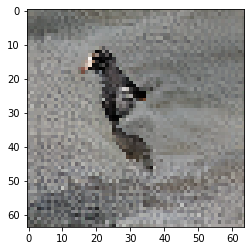

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 21

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 37.25118112564087 sec
Gen loss: 2.082996432051103, Gen valid loss: 1.2196088669099783, Gen attr loss: 0.8635655736858606, Disc valid loss: 1.1084775370634021, Disc valid real loss: 0.5663726695669375, Disc valid fake loss: 0.5421048670926392, Disc attr loss: 2.0218550795462074, Disc attr real loss: 1.1582895058603468, Disc attr fake loss: 0.8635655736858606
Time for epoch 2 is 37.18239164352417 sec
Gen loss: 2.0812662096850594, Gen valid loss: 1.2192150480378934, Gen attr loss: 0.8622296521980265, Disc valid loss: 1.1109103894815213, Disc valid real loss: 0.5716449981782494, Disc valid fake loss: 0.5392653881534328, Disc attr loss: 2.020021052218388, Disc attr real loss: 1.1577914000203615, Disc attr fake loss: 0.8622296521980265
Time for epoch 3 is 37.34255838394165 sec
Gen loss: 2.077831555511247, Gen valid loss: 1.2204767337982572, Gen attr loss: 0

Time for epoch 23 is 37.3401997089386 sec
Gen loss: 2.0766025584564622, Gen valid loss: 1.2171196577348684, Gen attr loss: 0.8596616130534226, Disc valid loss: 1.1127169679820053, Disc valid real loss: 0.5661998194084581, Disc valid fake loss: 0.5465171518849163, Disc attr loss: 2.0153319695131566, Disc attr real loss: 1.155670356459734, Disc attr fake loss: 0.8596616130534226
Time for epoch 24 is 37.37784481048584 sec
Gen loss: 2.092291082147014, Gen valid loss: 1.2163551937596908, Gen attr loss: 0.8761060076354319, Disc valid loss: 1.111318505391842, Disc valid real loss: 0.5672397819476399, Disc valid fake loss: 0.5440787222327256, Disc attr loss: 2.032273248928349, Disc attr real loss: 1.1561672412929174, Disc attr fake loss: 0.8761060076354319
Time for epoch 25 is 37.31951427459717 sec
Gen loss: 2.0920813006114183, Gen valid loss: 1.2236727474504694, Gen attr loss: 0.8685860843839361, Disc valid loss: 1.103441207066461, Disc valid real loss: 0.5682407103095274, Disc valid fake los

Time for epoch 45 is 37.36275577545166 sec
Gen loss: 2.077820552073843, Gen valid loss: 1.2167513499738078, Gen attr loss: 0.8612469399201514, Disc valid loss: 1.112383499216581, Disc valid real loss: 0.5710040530376641, Disc valid fake loss: 0.5413794443213197, Disc attr loss: 2.0151202822442302, Disc attr real loss: 1.1538733423240786, Disc attr fake loss: 0.8612469399201514
Time for epoch 46 is 37.3373863697052 sec
Gen loss: 2.0752080216963438, Gen valid loss: 1.2079305729568812, Gen attr loss: 0.8674476768589279, Disc valid loss: 1.116567966414661, Disc valid real loss: 0.5752538930432907, Disc valid fake loss: 0.5413140711907126, Disc attr loss: 2.0212338292178744, Disc attr real loss: 1.1537861523589468, Disc attr fake loss: 0.8674476768589279
Time for epoch 47 is 37.448259592056274 sec
Gen loss: 2.0710997090430117, Gen valid loss: 1.211895057664008, Gen attr loss: 0.8593808977907589, Disc valid loss: 1.1125465828551833, Disc valid real loss: 0.5695184801975239, Disc valid fake l

Time for epoch 67 is 37.37060546875 sec
Gen loss: 2.077687223429279, Gen valid loss: 1.2136822073117182, Gen attr loss: 0.8641797473760156, Disc valid loss: 1.109983288498752, Disc valid real loss: 0.5680088360458209, Disc valid fake loss: 0.5419744509991592, Disc attr loss: 2.0162314336474347, Disc attr real loss: 1.1520516862714194, Disc attr fake loss: 0.8641797473760156
Time for epoch 68 is 37.297417879104614 sec
Gen loss: 2.0723284867397815, Gen valid loss: 1.2093460246476377, Gen attr loss: 0.8631555441272291, Disc valid loss: 1.1188837338269242, Disc valid real loss: 0.5720400592175926, Disc valid fake loss: 0.5468436761438685, Disc attr loss: 2.0150461747717405, Disc attr real loss: 1.1518906306445114, Disc attr fake loss: 0.8631555441272291
Time for epoch 69 is 37.66887450218201 sec
Gen loss: 2.0822537985597522, Gen valid loss: 1.21655649673648, Gen attr loss: 0.8658726294512348, Disc valid loss: 1.1090226058714434, Disc valid real loss: 0.5686717682737645, Disc valid fake los

Time for epoch 89 is 37.634666442871094 sec
Gen loss: 2.079055535437938, Gen valid loss: 1.216742069256015, Gen attr loss: 0.8624905813031081, Disc valid loss: 1.1112676560071102, Disc valid real loss: 0.5679643599967646, Disc valid fake loss: 0.5433032935066275, Disc attr loss: 2.012872827085376, Disc attr real loss: 1.150382245782268, Disc attr fake loss: 0.8624905813031081
Time for epoch 90 is 37.60474944114685 sec
Gen loss: 2.0916950111466694, Gen valid loss: 1.2217226937857424, Gen attr loss: 0.8701480961427456, Disc valid loss: 1.1013292962619605, Disc valid real loss: 0.5611135202048594, Disc valid fake loss: 0.5402157771070475, Disc attr loss: 2.0204863218757194, Disc attr real loss: 1.150338225732974, Disc attr fake loss: 0.8701480961427456
Time for epoch 91 is 37.513134479522705 sec
Gen loss: 2.090396164878597, Gen valid loss: 1.2284169242310976, Gen attr loss: 0.8621623508006253, Disc valid loss: 1.1043260842157896, Disc valid real loss: 0.5661424993661038, Disc valid fake l

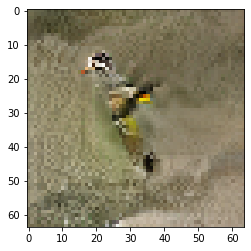

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 22

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 37.504541635513306 sec
Gen loss: 2.0606175350949045, Gen valid loss: 1.1997630361942095, Gen attr loss: 0.8610238528187036, Disc valid loss: 1.1185178517649168, Disc valid real loss: 0.5707811184207275, Disc valid fake loss: 0.5477367341518402, Disc attr loss: 2.010057517506566, Disc attr real loss: 1.1490336646878623, Disc attr fake loss: 0.8610238528187036
Time for epoch 2 is 37.45883870124817 sec
Gen loss: 2.062800271078177, Gen valid loss: 1.2098186163075249, Gen attr loss: 0.8531599703843031, Disc valid loss: 1.1098299914905372, Disc valid real loss: 0.5675623075264257, Disc valid fake loss: 0.542267684287172, Disc attr loss: 2.0021011243021585, Disc attr real loss: 1.1489411539178553, Disc attr fake loss: 0.8531599703843031
Time for epoch 3 is 37.471718072891235 sec
Gen loss: 2.08404820010591, Gen valid loss: 1.2201599031282957, Gen attr loss: 0

Time for epoch 23 is 37.423651456832886 sec
Gen loss: 2.0829479862357867, Gen valid loss: 1.2180197792970715, Gen attr loss: 0.8651046551016934, Disc valid loss: 1.1189053927656758, Disc valid real loss: 0.5740717836027223, Disc valid fake loss: 0.5448336115051414, Disc attr loss: 2.012476650195393, Disc attr real loss: 1.1473719950936998, Disc attr fake loss: 0.8651046551016934
Time for epoch 24 is 37.454161643981934 sec
Gen loss: 2.0848404601983583, Gen valid loss: 1.2242154217347867, Gen attr loss: 0.8608067295738675, Disc valid loss: 1.103100749373759, Disc valid real loss: 0.5665216238356541, Disc valid fake loss: 0.5365791296571251, Disc attr loss: 2.0082992326599474, Disc attr real loss: 1.1474925030860796, Disc attr fake loss: 0.8608067295738675
Time for epoch 25 is 37.452202796936035 sec
Gen loss: 2.085792532781275, Gen valid loss: 1.217796266240479, Gen attr loss: 0.8681710680648886, Disc valid loss: 1.1074279940871365, Disc valid real loss: 0.5690161983172098, Disc valid fak

Time for epoch 45 is 37.54385280609131 sec
Gen loss: 2.0695719302185185, Gen valid loss: 1.210267694823464, Gen attr loss: 0.8594796231122521, Disc valid loss: 1.1154906672190845, Disc valid real loss: 0.5729974977530761, Disc valid fake loss: 0.5424931671238205, Disc attr loss: 2.004755957016777, Disc attr real loss: 1.1452763339045249, Disc attr fake loss: 0.8594796231122521
Time for epoch 46 is 37.52033972740173 sec
Gen loss: 2.08896228323784, Gen valid loss: 1.222078246152821, Gen attr loss: 0.8670615267947437, Disc valid loss: 1.1128443860749242, Disc valid real loss: 0.5702542567317724, Disc valid fake loss: 0.5425901308776887, Disc attr loss: 2.0125381457127207, Disc attr real loss: 1.145476618917977, Disc attr fake loss: 0.8670615267947437
Time for epoch 47 is 37.6398229598999 sec
Gen loss: 2.0783702681058145, Gen valid loss: 1.208380620492506, Gen attr loss: 0.8701587472827776, Disc valid loss: 1.109154700263729, Disc valid real loss: 0.5688662054900554, Disc valid fake loss: 

Time for epoch 67 is 37.61681652069092 sec
Gen loss: 2.085900758340107, Gen valid loss: 1.224030297461564, Gen attr loss: 0.862051439802175, Disc valid loss: 1.1054776693747295, Disc valid real loss: 0.5667816367414262, Disc valid fake loss: 0.5386960312602965, Disc attr loss: 2.0054763658906065, Disc attr real loss: 1.1434249260884313, Disc attr fake loss: 0.862051439802175
Time for epoch 68 is 37.58781552314758 sec
Gen loss: 2.0623315133376496, Gen valid loss: 1.2111238220196752, Gen attr loss: 0.851387548252819, Disc valid loss: 1.1168074645001067, Disc valid real loss: 0.5697644018545384, Disc valid fake loss: 0.5470430638570449, Disc attr loss: 1.9952406230657727, Disc attr real loss: 1.1438530748129536, Disc attr fake loss: 0.851387548252819
Time for epoch 69 is 37.50173616409302 sec
Gen loss: 2.0695933019565698, Gen valid loss: 1.2088389112374325, Gen attr loss: 0.8609283301565382, Disc valid loss: 1.116280639720803, Disc valid real loss: 0.572965104486238, Disc valid fake loss:

Time for epoch 89 is 37.59857177734375 sec
Gen loss: 2.0742793877919516, Gen valid loss: 1.2140060979822465, Gen attr loss: 0.860450057317894, Disc valid loss: 1.1097171582826755, Disc valid real loss: 0.5679067706027974, Disc valid fake loss: 0.5418103894567102, Disc attr loss: 2.002024050650558, Disc attr real loss: 1.1415739933326638, Disc attr fake loss: 0.860450057317894
Time for epoch 90 is 37.7766637802124 sec
Gen loss: 2.0776900221015704, Gen valid loss: 1.2232029179570474, Gen attr loss: 0.8546713635850405, Disc valid loss: 1.1050032269017807, Disc valid real loss: 0.5659972105407456, Disc valid fake loss: 0.5390060150687933, Disc attr loss: 1.996851968086832, Disc attr real loss: 1.1421806045017915, Disc attr fake loss: 0.8546713635850405
Time for epoch 91 is 37.5714590549469 sec
Gen loss: 2.0747020919794634, Gen valid loss: 1.2087880227623917, Gen attr loss: 0.8660854135102373, Disc valid loss: 1.122197238087331, Disc valid real loss: 0.5751350543040247, Disc valid fake loss

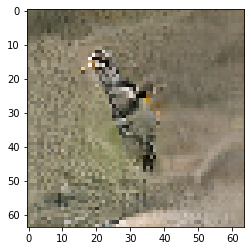

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 23

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.60616612434387 sec
Gen loss: 2.0742480732238064, Gen valid loss: 1.2184627201499008, Gen attr loss: 0.8559665864076071, Disc valid loss: 1.1094961993416474, Disc valid real loss: 0.5647344738648836, Disc valid fake loss: 0.5447617276574215, Disc attr loss: 1.9969600398689105, Disc attr real loss: 1.1409934534613033, Disc attr fake loss: 0.8559665864076071
Time for epoch 2 is 38.43772840499878 sec
Gen loss: 2.080119971337357, Gen valid loss: 1.2195132126006976, Gen attr loss: 0.860786114120225, Disc valid loss: 1.103001757204371, Disc valid real loss: 0.5642715226505507, Disc valid fake loss: 0.5387302359268271, Disc attr loss: 2.0015202699314933, Disc attr real loss: 1.1407341558112685, Disc attr fake loss: 0.860786114120225
Time for epoch 3 is 37.90914559364319 sec
Gen loss: 2.087734765799711, Gen valid loss: 1.2238241001196346, Gen attr loss: 0.8

Time for epoch 23 is 37.45829176902771 sec
Gen loss: 2.0835187994044646, Gen valid loss: 1.2270020136665198, Gen attr loss: 0.8567019251950065, Disc valid loss: 1.1133583809948226, Disc valid real loss: 0.5700840036558911, Disc valid fake loss: 0.5432743762082201, Disc attr loss: 1.996998868660552, Disc attr real loss: 1.1402969434655457, Disc attr fake loss: 0.8567019251950065
Time for epoch 24 is 37.41690468788147 sec
Gen loss: 2.0824571757458736, Gen valid loss: 1.2201502150313317, Gen attr loss: 0.8624857812716062, Disc valid loss: 1.1064740706911578, Disc valid real loss: 0.5680711760430478, Disc valid fake loss: 0.538402893840459, Disc attr loss: 2.0024205953448124, Disc attr real loss: 1.139934814073206, Disc attr fake loss: 0.8624857812716062
Time for epoch 25 is 37.43994188308716 sec
Gen loss: 2.073612108140134, Gen valid loss: 1.210037274735407, Gen attr loss: 0.8637479630912223, Disc valid loss: 1.1120684605626878, Disc valid real loss: 0.5669110313179048, Disc valid fake lo

Time for epoch 45 is 37.712100982666016 sec
Gen loss: 2.087550890154955, Gen valid loss: 1.2260132335065825, Gen attr loss: 0.8617197955203896, Disc valid loss: 1.107548399507838, Disc valid real loss: 0.5671655891872034, Disc valid fake loss: 0.5403828102398694, Disc attr loss: 1.9996285369079612, Disc attr real loss: 1.1379087413875715, Disc attr fake loss: 0.8617197955203896
Time for epoch 46 is 37.61972212791443 sec
Gen loss: 2.0685123192262522, Gen valid loss: 1.2146477066081391, Gen attr loss: 0.854044897931055, Disc valid loss: 1.1174162639188896, Disc valid real loss: 0.570994389493291, Disc valid fake loss: 0.5464218728102965, Disc attr loss: 1.992258500762102, Disc attr real loss: 1.138213602831047, Disc attr fake loss: 0.854044897931055
Time for epoch 47 is 37.52299189567566 sec
Gen loss: 2.07331030123279, Gen valid loss: 1.2136308460377743, Gen attr loss: 0.859856327213246, Disc valid loss: 1.1107438720338714, Disc valid real loss: 0.5703170907691242, Disc valid fake loss: 

Time for epoch 67 is 37.65773797035217 sec
Gen loss: 2.0819476106302526, Gen valid loss: 1.2177795341344384, Gen attr loss: 0.8643447845608885, Disc valid loss: 1.1101461996230975, Disc valid real loss: 0.5705476702067264, Disc valid fake loss: 0.5395985272357134, Disc attr loss: 2.0011929208993267, Disc attr real loss: 1.1368481363384382, Disc attr fake loss: 0.8643447845608885
Time for epoch 68 is 37.55570578575134 sec
Gen loss: 2.0689355848927486, Gen valid loss: 1.2102428894378952, Gen attr loss: 0.858868371503463, Disc valid loss: 1.1190072256052075, Disc valid real loss: 0.5704754058746141, Disc valid fake loss: 0.5485318203767141, Disc attr loss: 1.9956308188154122, Disc attr real loss: 1.1367624473119493, Disc attr fake loss: 0.858868371503463
Time for epoch 69 is 37.561179637908936 sec
Gen loss: 2.080309871089491, Gen valid loss: 1.2157940127985265, Gen attr loss: 0.8646913996233849, Disc valid loss: 1.1115461636364945, Disc valid real loss: 0.5701843450062967, Disc valid fake

Time for epoch 89 is 37.66304302215576 sec
Gen loss: 2.0796556579388255, Gen valid loss: 1.2229426923159985, Gen attr loss: 0.856895973850395, Disc valid loss: 1.1116944851914072, Disc valid real loss: 0.5687707747385754, Disc valid fake loss: 0.5429237100490063, Disc attr loss: 1.991950946287088, Disc attr real loss: 1.135054972436693, Disc attr fake loss: 0.856895973850395
Time for epoch 90 is 37.67752766609192 sec
Gen loss: 2.072998032660342, Gen valid loss: 1.2172282040926823, Gen attr loss: 0.8559504563246316, Disc valid loss: 1.1097296434366284, Disc valid real loss: 0.5648022718868928, Disc valid fake loss: 0.5449273713074403, Disc attr loss: 1.991117652515732, Disc attr real loss: 1.1351671961911003, Disc attr fake loss: 0.8559504563246316
Time for epoch 91 is 37.619808197021484 sec
Gen loss: 2.057693175507109, Gen valid loss: 1.2021652561862295, Gen attr loss: 0.8557011365567443, Disc valid loss: 1.124650880088651, Disc valid real loss: 0.576806665274509, Disc valid fake loss:

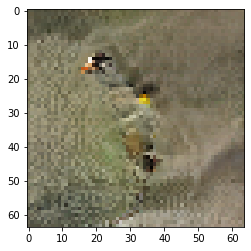

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 24

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 37.62049126625061 sec
Gen loss: 2.077053527198833, Gen valid loss: 1.2196992294898201, Gen attr loss: 0.8575353615975315, Disc valid loss: 1.1101849192203221, Disc valid real loss: 0.5675865452140973, Disc valid fake loss: 0.5425983736831644, Disc attr loss: 1.9920685646656728, Disc attr real loss: 1.1345332030681414, Disc attr fake loss: 0.8575353615975315
Time for epoch 2 is 37.67850375175476 sec
Gen loss: 2.0785382197801336, Gen valid loss: 1.2203514196362275, Gen attr loss: 0.8583677837519141, Disc valid loss: 1.1064374286953995, Disc valid real loss: 0.5654636681241395, Disc valid fake loss: 0.5409737592790185, Disc attr loss: 1.9925209912181223, Disc attr real loss: 1.1341532074662082, Disc attr fake loss: 0.8583677837519141
Time for epoch 3 is 37.60563945770264 sec
Gen loss: 2.082500268127214, Gen valid loss: 1.2178113840136748, Gen attr loss: 

Time for epoch 23 is 37.86750364303589 sec
Gen loss: 2.0755471504800687, Gen valid loss: 1.212170099339834, Gen attr loss: 0.8635513409366452, Disc valid loss: 1.1193063575723954, Disc valid real loss: 0.5732436616246294, Disc valid fake loss: 0.546062693524813, Disc attr loss: 1.9959928289984623, Disc attr real loss: 1.132441488061817, Disc attr fake loss: 0.8635513409366452
Time for epoch 24 is 37.92682337760925 sec
Gen loss: 2.0687710043537586, Gen valid loss: 1.20285213914344, Gen attr loss: 0.8660872329864399, Disc valid loss: 1.1187948939923025, Disc valid real loss: 0.5727484598553924, Disc valid fake loss: 0.5460464347022659, Disc attr loss: 1.9988277210452692, Disc attr real loss: 1.1327404880588294, Disc attr fake loss: 0.8660872329864399
Time for epoch 25 is 37.6710102558136 sec
Gen loss: 2.0592785246650056, Gen valid loss: 1.2061688383097249, Gen attr loss: 0.8532861215958427, Disc valid loss: 1.116312034084868, Disc valid real loss: 0.5721775975007675, Disc valid fake loss

Time for epoch 45 is 37.71027684211731 sec
Gen loss: 2.0636699496892086, Gen valid loss: 1.2090087957821565, Gen attr loss: 0.8548382246074314, Disc valid loss: 1.1134950967662056, Disc valid real loss: 0.5725410195385537, Disc valid fake loss: 0.5409540787621888, Disc attr loss: 1.9865129284742402, Disc attr real loss: 1.1316747038668087, Disc attr fake loss: 0.8548382246074314
Time for epoch 46 is 37.70240664482117 sec
Gen loss: 2.0791004346961253, Gen valid loss: 1.2190909345298602, Gen attr loss: 0.8601889371225827, Disc valid loss: 1.1089367073402818, Disc valid real loss: 0.5654170120634684, Disc valid fake loss: 0.5435196966498201, Disc attr loss: 1.9917075025033821, Disc attr real loss: 1.1315185653807993, Disc attr fake loss: 0.8601889371225827
Time for epoch 47 is 37.743311405181885 sec
Gen loss: 2.086291997413325, Gen valid loss: 1.2260352890019817, Gen attr loss: 0.8604394956655942, Disc valid loss: 1.104435656936511, Disc valid real loss: 0.5653327942540652, Disc valid fak

Time for epoch 67 is 37.729026556015015 sec
Gen loss: 2.086738791892199, Gen valid loss: 1.223579495741423, Gen attr loss: 0.8633394073341597, Disc valid loss: 1.1060402776167644, Disc valid real loss: 0.5641624148945176, Disc valid fake loss: 0.5418778647413744, Disc attr loss: 1.9933166637976318, Disc attr real loss: 1.129977256463472, Disc attr fake loss: 0.8633394073341597
Time for epoch 68 is 37.685174226760864 sec
Gen loss: 2.067687750508792, Gen valid loss: 1.2082791916400113, Gen attr loss: 0.8595828998702651, Disc valid loss: 1.1183271857135018, Disc valid real loss: 0.5691338103153518, Disc valid fake loss: 0.5491933783056936, Disc attr loss: 1.989159006090345, Disc attr real loss: 1.12957610622008, Disc attr fake loss: 0.8595828998702651
Time for epoch 69 is 37.75820302963257 sec
Gen loss: 2.0771451064241613, Gen valid loss: 1.2149097837083709, Gen attr loss: 0.8624115566897198, Disc valid loss: 1.110570778207081, Disc valid real loss: 0.5664145987692887, Disc valid fake los

Time for epoch 89 is 37.94130778312683 sec
Gen loss: 2.052036605230192, Gen valid loss: 1.1929581559447415, Gen attr loss: 0.859245291731868, Disc valid loss: 1.1187093984789964, Disc valid real loss: 0.5731555448799599, Disc valid fake loss: 0.5455538538413319, Disc attr loss: 1.9877587266084624, Disc attr real loss: 1.1285134348765944, Disc attr fake loss: 0.859245291731868
Time for epoch 90 is 38.06672763824463 sec
Gen loss: 2.0656565017493436, Gen valid loss: 1.2081438934576867, Gen attr loss: 0.8576878223638871, Disc valid loss: 1.1099440676733083, Disc valid real loss: 0.5641464986775303, Disc valid fake loss: 0.5457975732763285, Disc attr loss: 1.9860642439304652, Disc attr real loss: 1.1283764215665781, Disc attr fake loss: 0.8576878223638871
Time for epoch 91 is 37.86327147483826 sec
Gen loss: 2.0743373109073175, Gen valid loss: 1.2125706280150064, Gen attr loss: 0.8619419835447296, Disc valid loss: 1.1163458203881738, Disc valid real loss: 0.5691654992297412, Disc valid fake 

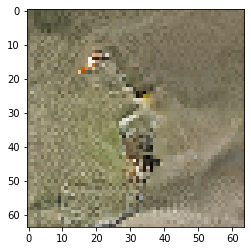

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 25

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 37.92749381065369 sec
Gen loss: 2.069360699757005, Gen valid loss: 1.2078449057369698, Gen attr loss: 0.8616888611943418, Disc valid loss: 1.113561893058663, Disc valid real loss: 0.5665567318598429, Disc valid fake loss: 0.5470051630564176, Disc attr loss: 1.9889887529336987, Disc attr real loss: 1.1272998917393569, Disc attr fake loss: 0.8616888611943418
Time for epoch 2 is 37.86053204536438 sec
Gen loss: 2.082398978675284, Gen valid loss: 1.220917011018045, Gen attr loss: 0.861661580843008, Disc valid loss: 1.1060250752017426, Disc valid real loss: 0.5647033183232233, Disc valid fake loss: 0.5413217561516336, Disc attr loss: 1.9894463321380822, Disc attr real loss: 1.1277847512950743, Disc attr fake loss: 0.861661580843008
Time for epoch 3 is 37.87120962142944 sec
Gen loss: 2.0766349572153273, Gen valid loss: 1.215348615394375, Gen attr loss: 0.861

Time for epoch 23 is 38.04437255859375 sec
Gen loss: 2.0688048843445817, Gen valid loss: 1.2080495649883094, Gen attr loss: 0.8609288612678445, Disc valid loss: 1.1237247610479835, Disc valid real loss: 0.5754019062370466, Disc valid fake loss: 0.5483228546494068, Disc attr loss: 1.9871599670994249, Disc attr real loss: 1.1262311058315804, Disc attr fake loss: 0.8609288612678445
Time for epoch 24 is 37.976940393447876 sec
Gen loss: 2.0782937244348085, Gen valid loss: 1.2156178306757919, Gen attr loss: 0.8628522640644374, Disc valid loss: 1.112082601562748, Disc valid real loss: 0.5676873009702378, Disc valid fake loss: 0.5443952961504298, Disc attr loss: 1.989375218950959, Disc attr real loss: 1.1265229548865217, Disc attr fake loss: 0.8628522640644374
Time for epoch 25 is 37.906108379364014 sec
Gen loss: 2.083425514743257, Gen valid loss: 1.220867686316896, Gen attr loss: 0.8627368870789442, Disc valid loss: 1.105755583380619, Disc valid real loss: 0.5665111746083753, Disc valid fake 

Time for epoch 45 is 38.08648920059204 sec
Gen loss: 2.0810895147039314, Gen valid loss: 1.22412734319201, Gen attr loss: 0.857145636062312, Disc valid loss: 1.1074061165980207, Disc valid real loss: 0.5643679423706964, Disc valid fake loss: 0.5430381719659014, Disc attr loss: 1.9820528091776985, Disc attr real loss: 1.1249071731153866, Disc attr fake loss: 0.857145636062312
Time for epoch 46 is 38.05822491645813 sec
Gen loss: 2.068419474573316, Gen valid loss: 1.2060599186556127, Gen attr loss: 0.8625313071054495, Disc valid loss: 1.1243927294645852, Disc valid real loss: 0.5716377434530232, Disc valid fake loss: 0.5527549862538573, Disc attr loss: 1.9874227130962259, Disc attr real loss: 1.1248914059907764, Disc attr fake loss: 0.8625313071054495
Time for epoch 47 is 38.01857352256775 sec
Gen loss: 2.0564751631522245, Gen valid loss: 1.1882834092065249, Gen attr loss: 0.8683517181130282, Disc valid loss: 1.124548546182431, Disc valid real loss: 0.5747067492990313, Disc valid fake los

Time for epoch 67 is 38.0787627696991 sec
Gen loss: 2.075607122444525, Gen valid loss: 1.2163736206406177, Gen attr loss: 0.8594119729711435, Disc valid loss: 1.1094836794587009, Disc valid real loss: 0.5689469568613099, Disc valid fake loss: 0.5405367255856998, Disc attr loss: 1.9830586545189546, Disc attr real loss: 1.123646681547811, Disc attr fake loss: 0.8594119729711435
Time for epoch 68 is 38.00787663459778 sec
Gen loss: 2.0827432486422985, Gen valid loss: 1.2209089013942211, Gen attr loss: 0.8620137795200192, Disc valid loss: 1.1096352800767273, Disc valid real loss: 0.5688804973593249, Disc valid fake loss: 0.5407547807790399, Disc attr loss: 1.9858800261647398, Disc attr real loss: 1.1238662466447205, Disc attr fake loss: 0.8620137795200192
Time for epoch 69 is 38.01714730262756 sec
Gen loss: 2.0816647702762427, Gen valid loss: 1.2216501126121375, Gen attr loss: 0.8601953697398426, Disc valid loss: 1.1061544053276704, Disc valid real loss: 0.5638827355250433, Disc valid fake 

Time for epoch 89 is 38.10316228866577 sec
Gen loss: 2.0817318621689713, Gen valid loss: 1.229076355291899, Gen attr loss: 0.852843610090292, Disc valid loss: 1.1020756439787909, Disc valid real loss: 0.5673709409185218, Disc valid fake loss: 0.5347047028179738, Disc attr loss: 1.9762298547155488, Disc attr real loss: 1.123386244625257, Disc attr fake loss: 0.852843610090292
Time for epoch 90 is 38.10891079902649 sec
Gen loss: 2.068573764023096, Gen valid loss: 1.2149834359887492, Gen attr loss: 0.8537709217084456, Disc valid loss: 1.1128267821903797, Disc valid real loss: 0.5707535806710158, Disc valid fake loss: 0.5420731995002364, Disc attr loss: 1.9766263031378024, Disc attr real loss: 1.122855381429357, Disc attr fake loss: 0.8537709217084456
Time for epoch 91 is 38.087716579437256 sec
Gen loss: 2.088660048275459, Gen valid loss: 1.2273518924467608, Gen attr loss: 0.8614910710148695, Disc valid loss: 1.110721836406687, Disc valid real loss: 0.567663780638196, Disc valid fake loss:

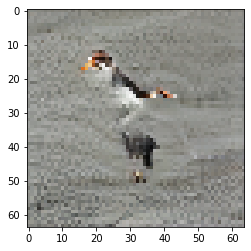

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 26

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.16578435897827 sec
Gen loss: 2.0721761627895074, Gen valid loss: 1.2220422392938195, Gen attr loss: 0.8503197701319769, Disc valid loss: 1.1128998374551293, Disc valid real loss: 0.5718304791101595, Disc valid fake loss: 0.5410693585065, Disc attr loss: 1.9730412746832622, Disc attr real loss: 1.1227215045512853, Disc attr fake loss: 0.8503197701319769
Time for epoch 2 is 38.01257109642029 sec
Gen loss: 2.074419422201348, Gen valid loss: 1.2159650942820521, Gen attr loss: 0.8586329809695401, Disc valid loss: 1.1129210785152466, Disc valid real loss: 0.5647623733614842, Disc valid fake loss: 0.5481587081420712, Disc attr loss: 1.981153750645759, Disc attr real loss: 1.122520769676219, Disc attr fake loss: 0.8586329809695401
Time for epoch 3 is 37.89827609062195 sec
Gen loss: 2.0776894027947734, Gen valid loss: 1.2223600535211847, Gen attr loss: 0.85

Time for epoch 23 is 38.246352672576904 sec
Gen loss: 2.0820415578883513, Gen valid loss: 1.2219207286834717, Gen attr loss: 0.8603016222072487, Disc valid loss: 1.1128087103528381, Disc valid real loss: 0.5701609702129674, Disc valid fake loss: 0.5426477388476292, Disc attr loss: 1.9815655108389816, Disc attr real loss: 1.1212638886317328, Disc attr fake loss: 0.8603016222072487
Time for epoch 24 is 38.03707528114319 sec
Gen loss: 2.0732466069663444, Gen valid loss: 1.2151163398088802, Gen attr loss: 0.8583086640208071, Disc valid loss: 1.1113969421968228, Disc valid real loss: 0.5685345286599343, Disc valid fake loss: 0.5428624099024589, Disc attr loss: 1.9796386164055284, Disc attr real loss: 1.1213299523847213, Disc attr fake loss: 0.8583086640208071
Time for epoch 25 is 38.09023427963257 sec
Gen loss: 2.0585482692330834, Gen valid loss: 1.2039670228635069, Gen attr loss: 0.8547558358045129, Disc valid loss: 1.1202130148081275, Disc valid real loss: 0.5706651180094173, Disc valid f

Time for epoch 45 is 38.02503800392151 sec
Gen loss: 2.0682879440829685, Gen valid loss: 1.216839716686466, Gen attr loss: 0.851630813545651, Disc valid loss: 1.1118361402333268, Disc valid real loss: 0.5676046924862436, Disc valid fake loss: 0.5442314462125463, Disc attr loss: 1.972075412428476, Disc attr real loss: 1.120444598882825, Disc attr fake loss: 0.851630813545651
Time for epoch 46 is 38.08211851119995 sec
Gen loss: 2.066389517732429, Gen valid loss: 1.2165586528416248, Gen attr loss: 0.8500141242978373, Disc valid loss: 1.1121034727187014, Disc valid real loss: 0.5687396515029556, Disc valid fake loss: 0.5433638198427392, Disc attr loss: 1.9700091781654978, Disc attr real loss: 1.1199950538676606, Disc attr fake loss: 0.8500141242978373
Time for epoch 47 is 38.060981035232544 sec
Gen loss: 2.0721408959003647, Gen valid loss: 1.222992890410953, Gen attr loss: 0.8493348183993724, Disc valid loss: 1.1111559953469894, Disc valid real loss: 0.5667422945260355, Disc valid fake los

Time for epoch 67 is 38.085493087768555 sec
Gen loss: 2.0751403134043622, Gen valid loss: 1.219642460507752, Gen attr loss: 0.8556798234541565, Disc valid loss: 1.111234663947811, Disc valid real loss: 0.5676935438702746, Disc valid fake loss: 0.543541120562127, Disc attr loss: 1.9747868351496978, Disc attr real loss: 1.1191070116955413, Disc attr fake loss: 0.8556798234541565
Time for epoch 68 is 38.08056044578552 sec
Gen loss: 2.0822526064668567, Gen valid loss: 1.2187176256321957, Gen attr loss: 0.8637124686060236, Disc valid loss: 1.1176604990390582, Disc valid real loss: 0.5711386765083324, Disc valid fake loss: 0.5465218230960814, Disc attr loss: 1.9829388881117347, Disc attr real loss: 1.1192264195057111, Disc attr fake loss: 0.8637124686060236
Time for epoch 69 is 38.38620662689209 sec
Gen loss: 2.0777226282652155, Gen valid loss: 1.2140069161327227, Gen attr loss: 0.8638907532058757, Disc valid loss: 1.110943252801249, Disc valid real loss: 0.568300347744934, Disc valid fake l

Time for epoch 89 is 38.17869305610657 sec
Gen loss: 2.077099683485057, Gen valid loss: 1.2214995390031396, Gen attr loss: 0.8557829897255109, Disc valid loss: 1.1053875571667018, Disc valid real loss: 0.5672875171108298, Disc valid fake loss: 0.5381000370675633, Disc attr loss: 1.9735578422946982, Disc attr real loss: 1.1177748525691873, Disc attr fake loss: 0.8557829897255109
Time for epoch 90 is 38.23129200935364 sec
Gen loss: 2.077757975273339, Gen valid loss: 1.2222463338355707, Gen attr loss: 0.8556949058522377, Disc valid loss: 1.1096237250136811, Disc valid real loss: 0.5693755236259967, Disc valid fake loss: 0.5402482038914027, Disc attr loss: 1.973845455866196, Disc attr real loss: 1.1181505500139584, Disc attr fake loss: 0.8556949058522377
Time for epoch 91 is 38.19414758682251 sec
Gen loss: 2.0695249659582204, Gen valid loss: 1.2183201057801079, Gen attr loss: 0.8513883163289326, Disc valid loss: 1.1140084764175622, Disc valid real loss: 0.5707777517274789, Disc valid fake 

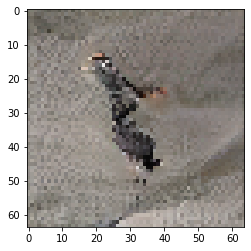

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 27

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.190518856048584 sec
Gen loss: 2.0727207124394775, Gen valid loss: 1.2182462745242648, Gen attr loss: 0.8546562249744488, Disc valid loss: 1.112218076136054, Disc valid real loss: 0.567037575290132, Disc valid fake loss: 0.5451805010882174, Disc attr loss: 1.9717325262907075, Disc attr real loss: 1.1170763013162588, Disc attr fake loss: 0.8546562249744488
Time for epoch 2 is 38.11517596244812 sec
Gen loss: 2.067550405254209, Gen valid loss: 1.21880162117604, Gen attr loss: 0.8489337064386383, Disc valid loss: 1.1145934585310255, Disc valid real loss: 0.5686651542580871, Disc valid fake loss: 0.5459283020922808, Disc attr loss: 1.9661598796766948, Disc attr real loss: 1.1172261732380564, Disc attr fake loss: 0.8489337064386383
Time for epoch 3 is 38.17318415641785 sec
Gen loss: 2.0607938275427675, Gen valid loss: 1.2044546620309515, Gen attr loss: 0.

Time for epoch 23 is 38.22268009185791 sec
Gen loss: 2.0584181734539952, Gen valid loss: 1.2049805433123415, Gen attr loss: 0.8536133042519009, Disc valid loss: 1.12548375355842, Disc valid real loss: 0.574282952117403, Disc valid fake loss: 0.5512007968374061, Disc attr loss: 1.969602233995267, Disc attr real loss: 1.1159889297433663, Disc attr fake loss: 0.8536133042519009
Time for epoch 24 is 38.26255488395691 sec
Gen loss: 2.0741594984602476, Gen valid loss: 1.2143451826682259, Gen attr loss: 0.859991479049207, Disc valid loss: 1.1102594284184257, Disc valid real loss: 0.5693557727627638, Disc valid fake loss: 0.5409036553326015, Disc attr loss: 1.97591725855985, Disc attr real loss: 1.1159257795106428, Disc attr fake loss: 0.859991479049207
Time for epoch 25 is 38.24617123603821 sec
Gen loss: 2.0632121986166894, Gen valid loss: 1.2126399692158065, Gen attr loss: 0.850753161157696, Disc valid loss: 1.1120989514883295, Disc valid real loss: 0.5646214914838796, Disc valid fake loss: 

Time for epoch 45 is 38.24738359451294 sec
Gen loss: 2.069165140309631, Gen valid loss: 1.214036727662332, Gen attr loss: 0.8553077686769852, Disc valid loss: 1.1116479822613683, Disc valid real loss: 0.5686336786443302, Disc valid fake loss: 0.5430143040208636, Disc attr loss: 1.9700310776227212, Disc attr real loss: 1.114723308945736, Disc attr fake loss: 0.8553077686769852
Time for epoch 46 is 38.28000068664551 sec
Gen loss: 2.082605661415472, Gen valid loss: 1.2219196406160266, Gen attr loss: 0.8608665251473424, Disc valid loss: 1.1140877368650461, Disc valid real loss: 0.5667039541209616, Disc valid fake loss: 0.5473837763636415, Disc attr loss: 1.975839725516353, Disc attr real loss: 1.1149732003690105, Disc attr fake loss: 0.8608665251473424
Time for epoch 47 is 38.23515343666077 sec
Gen loss: 2.0732347874783565, Gen valid loss: 1.2155579512681418, Gen attr loss: 0.8578556759893733, Disc valid loss: 1.1124940186658203, Disc valid real loss: 0.56897646616791, Disc valid fake loss

Time for epoch 67 is 38.34180188179016 sec
Gen loss: 2.071681716254733, Gen valid loss: 1.2127333719555924, Gen attr loss: 0.8591251345830881, Disc valid loss: 1.114420180236744, Disc valid real loss: 0.5706772952060389, Disc valid fake loss: 0.5437428852730004, Disc attr loss: 1.972956996300033, Disc attr real loss: 1.113831861716945, Disc attr fake loss: 0.8591251345830881
Time for epoch 68 is 38.43927216529846 sec
Gen loss: 2.0660065900342572, Gen valid loss: 1.2151312637458325, Gen attr loss: 0.8510573553199045, Disc valid loss: 1.1146195700498132, Disc valid real loss: 0.5678560103827376, Disc valid fake loss: 0.5467635587786595, Disc attr loss: 1.9650189650414114, Disc attr real loss: 1.1139616097215068, Disc attr fake loss: 0.8510573553199045
Time for epoch 69 is 38.393484115600586 sec
Gen loss: 2.0711512513923127, Gen valid loss: 1.2192707990566243, Gen attr loss: 0.8520640414258652, Disc valid loss: 1.112705120226232, Disc valid real loss: 0.5680509093331128, Disc valid fake l

Time for epoch 89 is 38.275081157684326 sec
Gen loss: 2.0655956097088533, Gen valid loss: 1.2143756739169278, Gen attr loss: 0.851401406898085, Disc valid loss: 1.1130986678891066, Disc valid real loss: 0.56909060518593, Disc valid fake loss: 0.5440080636723578, Disc attr loss: 1.9637845583401399, Disc attr real loss: 1.1123831514420548, Disc attr fake loss: 0.851401406898085
Time for epoch 90 is 38.304526567459106 sec
Gen loss: 2.069660546010749, Gen valid loss: 1.2138835417868967, Gen attr loss: 0.8559559540050786, Disc valid loss: 1.1144970933273233, Disc valid real loss: 0.567523568787872, Disc valid fake loss: 0.546973521147317, Disc attr loss: 1.9688447243799039, Disc attr real loss: 1.1128887703748254, Disc attr fake loss: 0.8559559540050786
Time for epoch 91 is 38.25589394569397 sec
Gen loss: 2.0752364358281703, Gen valid loss: 1.214768824215504, Gen attr loss: 0.8606446632524816, Disc valid loss: 1.1168623708774081, Disc valid real loss: 0.5687944444052895, Disc valid fake los

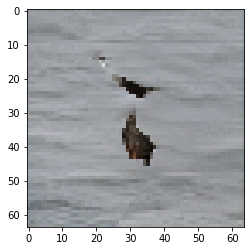

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 28

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.27958869934082 sec
Gen loss: 2.063655903022787, Gen valid loss: 1.2103842550176915, Gen attr loss: 0.8534501005963582, Disc valid loss: 1.1142053883573226, Disc valid real loss: 0.5656567617322048, Disc valid fake loss: 0.5485486262212924, Disc attr loss: 1.965351237837215, Disc attr real loss: 1.111901137240857, Disc attr fake loss: 0.8534501005963582
Time for epoch 2 is 38.261791467666626 sec
Gen loss: 2.064732565789365, Gen valid loss: 1.2078734508697904, Gen attr loss: 0.8570345236356989, Disc valid loss: 1.1181966990313232, Disc valid real loss: 0.5695214984701255, Disc valid fake loss: 0.548675200722728, Disc attr loss: 1.9691367674326186, Disc attr real loss: 1.1121022437969197, Disc attr fake loss: 0.8570345236356989
Time for epoch 3 is 38.32811450958252 sec
Gen loss: 2.0625820508817347, Gen valid loss: 1.2034895158395535, Gen attr loss: 0.

Time for epoch 23 is 38.26040267944336 sec
Gen loss: 2.0793422941916035, Gen valid loss: 1.2206784819522847, Gen attr loss: 0.8588447226741449, Disc valid loss: 1.1173206472461463, Disc valid real loss: 0.5697836698232305, Disc valid fake loss: 0.547536977584446, Disc attr loss: 1.9698556897439932, Disc attr real loss: 1.111010967069848, Disc attr fake loss: 0.8588447226741449
Time for epoch 24 is 38.29050087928772 sec
Gen loss: 2.0669993963344955, Gen valid loss: 1.2076508275215543, Gen attr loss: 0.8595226197061823, Disc valid loss: 1.1178036702034597, Disc valid real loss: 0.5693279626731303, Disc valid fake loss: 0.5484757124570004, Disc attr loss: 1.9702850450991292, Disc attr real loss: 1.110762425392947, Disc attr fake loss: 0.8595226197061823
Time for epoch 25 is 38.31244111061096 sec
Gen loss: 2.0541288594243325, Gen valid loss: 1.1941077213300275, Gen attr loss: 0.8601880886044283, Disc valid loss: 1.1256135023706328, Disc valid real loss: 0.5740089117673032, Disc valid fake 

Time for epoch 45 is 38.444254636764526 sec
Gen loss: 2.0155261470696466, Gen valid loss: 1.2352569707363925, Gen attr loss: 0.7804965367162131, Disc valid loss: 1.1065992719435755, Disc valid real loss: 0.5636785171703917, Disc valid fake loss: 0.5429207586499087, Disc attr loss: 1.8865113686416854, Disc attr real loss: 1.1060148319254723, Disc attr fake loss: 0.7804965367162131
Time for epoch 46 is 38.436683654785156 sec
Gen loss: 2.005813334369401, Gen valid loss: 1.2281413133228374, Gen attr loss: 0.7778971246910612, Disc valid loss: 1.1104796753343205, Disc valid real loss: 0.5657065828964316, Disc valid fake loss: 0.5447730887226943, Disc attr loss: 1.8827649426007982, Disc attr real loss: 1.1048678179097369, Disc attr fake loss: 0.7778971246910612
Time for epoch 47 is 38.48895239830017 sec
Gen loss: 2.0070174641725496, Gen valid loss: 1.2277533248834172, Gen attr loss: 0.7794882535611388, Disc valid loss: 1.108677038978432, Disc valid real loss: 0.5678761289694768, Disc valid fa

Time for epoch 67 is 38.376017570495605 sec
Gen loss: 2.0033278368352874, Gen valid loss: 1.2236594470535838, Gen attr loss: 0.7798902498997324, Disc valid loss: 1.1090290664334284, Disc valid real loss: 0.5672619970348792, Disc valid fake loss: 0.5417670689139585, Disc attr loss: 1.8731786285635579, Disc attr real loss: 1.0932883786638254, Disc attr fake loss: 0.7798902498997324
Time for epoch 68 is 38.39397358894348 sec
Gen loss: 1.9766461435695328, Gen valid loss: 1.2083864515712914, Gen attr loss: 0.768479634268174, Disc valid loss: 1.1200140428736927, Disc valid real loss: 0.574046482884787, Disc valid fake loss: 0.545967557727483, Disc attr loss: 1.8617300607647675, Disc attr real loss: 1.0932504264965937, Disc attr fake loss: 0.768479634268174
Time for epoch 69 is 38.394787073135376 sec
Gen loss: 1.9840499866945633, Gen valid loss: 1.2116801758122637, Gen attr loss: 0.772589342542457, Disc valid loss: 1.1143279038470613, Disc valid real loss: 0.5706527510955728, Disc valid fake 

Time for epoch 89 is 38.34752559661865 sec
Gen loss: 1.9780915439290405, Gen valid loss: 1.2076904801172292, Gen attr loss: 0.7706195852620815, Disc valid loss: 1.1206023697930623, Disc valid real loss: 0.5745657126754926, Disc valid fake loss: 0.5460366593789925, Disc attr loss: 1.8608068563750766, Disc attr real loss: 1.0901872711129952, Disc attr fake loss: 0.7706195852620815
Time for epoch 90 is 38.418694734573364 sec
Gen loss: 1.9766229491246747, Gen valid loss: 1.2132518425543457, Gen attr loss: 0.7635959105763009, Disc valid loss: 1.1109631068015162, Disc valid real loss: 0.567727556315864, Disc valid fake loss: 0.5432355524240148, Disc attr loss: 1.853346900242131, Disc attr real loss: 1.08975098966583, Disc attr fake loss: 0.7635959105763009
Time for epoch 91 is 38.360400915145874 sec
Gen loss: 1.9841067296702688, Gen valid loss: 1.2104370598870564, Gen attr loss: 0.7738879255162991, Disc valid loss: 1.1189541776328875, Disc valid real loss: 0.5720656132148857, Disc valid fake

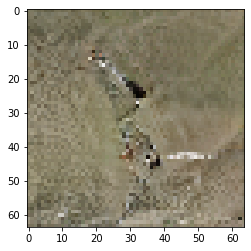

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 29

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.37107181549072 sec
Gen loss: 1.9961725835231585, Gen valid loss: 1.2186726268714037, Gen attr loss: 0.7777204153337453, Disc valid loss: 1.1152800735096298, Disc valid real loss: 0.5691619282815514, Disc valid fake loss: 0.546118145712669, Disc attr loss: 1.866509136145677, Disc attr real loss: 1.0887887208119318, Disc attr fake loss: 0.7777204153337453
Time for epoch 2 is 38.37097454071045 sec
Gen loss: 1.9962668124899308, Gen valid loss: 1.2258563673270104, Gen attr loss: 0.7706380387954919, Disc valid loss: 1.108980856613738, Disc valid real loss: 0.5626374798900067, Disc valid fake loss: 0.5463433741392482, Disc attr loss: 1.859363426684041, Disc attr real loss: 1.0887253878885492, Disc attr fake loss: 0.7706380387954919
Time for epoch 3 is 38.43609690666199 sec
Gen loss: 1.9824076726184627, Gen valid loss: 1.219080964885753, Gen attr loss: 0.7

Time for epoch 23 is 38.35987710952759 sec
Gen loss: 1.9756426336319466, Gen valid loss: 1.2109815835306639, Gen attr loss: 0.7648840811517503, Disc valid loss: 1.1224911359913627, Disc valid real loss: 0.5694504848663723, Disc valid fake loss: 0.5530406545978898, Disc attr loss: 1.850908694390036, Disc attr real loss: 1.0860246132382856, Disc attr fake loss: 0.7648840811517503
Time for epoch 24 is 38.35730528831482 sec
Gen loss: 1.9955302602876492, Gen valid loss: 1.218054190399201, Gen attr loss: 0.7776962323240472, Disc valid loss: 1.1131010719431125, Disc valid real loss: 0.5656048645010485, Disc valid fake loss: 0.5474962059882921, Disc attr loss: 1.8635999571663255, Disc attr real loss: 1.0859037248422783, Disc attr fake loss: 0.7776962323240472
Time for epoch 25 is 38.39562654495239 sec
Gen loss: 1.9963144151175893, Gen valid loss: 1.2236333828631456, Gen attr loss: 0.7729063794864872, Disc valid loss: 1.1094323703590123, Disc valid real loss: 0.5666427642187775, Disc valid fake

Time for epoch 45 is 38.37509298324585 sec
Gen loss: 1.989861688316676, Gen valid loss: 1.2177488047902176, Gen attr loss: 0.7723355734251379, Disc valid loss: 1.1098015444065497, Disc valid real loss: 0.5640244570366413, Disc valid fake loss: 0.5457770863199621, Disc attr loss: 1.8570949165478632, Disc attr real loss: 1.0847593431227252, Disc attr fake loss: 0.7723355734251379
Time for epoch 46 is 38.376559019088745 sec
Gen loss: 1.9992466302422005, Gen valid loss: 1.2305916358784932, Gen attr loss: 0.7688858279690833, Disc valid loss: 1.111492515741002, Disc valid real loss: 0.5679797393681234, Disc valid fake loss: 0.5435127760498182, Disc attr loss: 1.853162595896217, Disc attr real loss: 1.0842767679271337, Disc attr fake loss: 0.7688858279690833
Time for epoch 47 is 38.40442490577698 sec
Gen loss: 1.9905992672049255, Gen valid loss: 1.219421138769889, Gen attr loss: 0.7714021194594985, Disc valid loss: 1.1104111786134199, Disc valid real loss: 0.5667662082648859, Disc valid fake 

Time for epoch 67 is 38.411885499954224 sec
Gen loss: 1.978097757026755, Gen valid loss: 1.2077955503450823, Gen attr loss: 0.7705208265038364, Disc valid loss: 1.1171093392501354, Disc valid real loss: 0.5703178600567144, Disc valid fake loss: 0.5467914785473005, Disc attr loss: 1.8532555382749252, Disc attr real loss: 1.0827347117710888, Disc attr fake loss: 0.7705208265038364
Time for epoch 68 is 38.07753610610962 sec
Gen loss: 1.9710931755339873, Gen valid loss: 1.2027044087890688, Gen attr loss: 0.7686057945254049, Disc valid loss: 1.1222141267161383, Disc valid real loss: 0.5745270421834496, Disc valid fake loss: 0.5476870850980443, Disc attr loss: 1.8511305682381318, Disc attr real loss: 1.0825247737127268, Disc attr fake loss: 0.7686057945254049
Time for epoch 69 is 38.46068620681763 sec
Gen loss: 1.983404905169314, Gen valid loss: 1.2175558107655222, Gen attr loss: 0.766074818808858, Disc valid loss: 1.1128739984377936, Disc valid real loss: 0.5713552281785463, Disc valid fake

Time for epoch 89 is 38.23533058166504 sec
Gen loss: 1.981908154681446, Gen valid loss: 1.2100183141586904, Gen attr loss: 0.7721087764595259, Disc valid loss: 1.1157378551113573, Disc valid real loss: 0.5696946517400302, Disc valid fake loss: 0.5460432048250989, Disc attr loss: 1.8528627614341777, Disc attr real loss: 1.0807539849746517, Disc attr fake loss: 0.7721087764595259
Time for epoch 90 is 38.35263991355896 sec
Gen loss: 1.9856558724793638, Gen valid loss: 1.211592705915291, Gen attr loss: 0.7742818136848408, Disc valid loss: 1.1150593218118519, Disc valid real loss: 0.5736952365898504, Disc valid fake loss: 0.5413640871603638, Disc attr loss: 1.8551219438472737, Disc attr real loss: 1.0808401301624329, Disc attr fake loss: 0.7742818136848408
Time for epoch 91 is 38.27083873748779 sec
Gen loss: 1.9879581340283237, Gen valid loss: 1.2109274612209662, Gen attr loss: 0.7772474930215334, Disc valid loss: 1.1191908445784715, Disc valid real loss: 0.5675810009321869, Disc valid fake

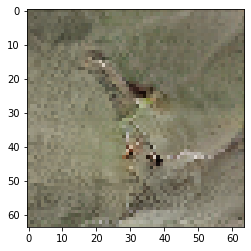

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 30

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.05705976486206 sec
Gen loss: 1.9880541346583587, Gen valid loss: 1.2208629365212873, Gen attr loss: 0.7674179046457699, Disc valid loss: 1.114500037699857, Disc valid real loss: 0.5663810600110186, Disc valid fake loss: 0.5481189790618451, Disc attr loss: 1.8470364473053433, Disc attr real loss: 1.0796185426595735, Disc attr fake loss: 0.7674179046457699
Time for epoch 2 is 38.392587423324585 sec
Gen loss: 1.9779575404112901, Gen valid loss: 1.2102168168478864, Gen attr loss: 0.7679618330505805, Disc valid loss: 1.117193722951057, Disc valid real loss: 0.568878319689898, Disc valid fake loss: 0.5483154028573334, Disc attr loss: 1.8480885505353208, Disc attr real loss: 1.0801267174847404, Disc attr fake loss: 0.7679618330505805
Time for epoch 3 is 38.015377044677734 sec
Gen loss: 2.0010288304429715, Gen valid loss: 1.2310925676893736, Gen attr loss:

Time for epoch 23 is 37.88328409194946 sec
Gen loss: 1.9637441560827942, Gen valid loss: 1.1989363897137526, Gen attr loss: 0.7650247049848562, Disc valid loss: 1.127693343614821, Disc valid real loss: 0.578465971035686, Disc valid fake loss: 0.5492273739521419, Disc attr loss: 1.8435482717141873, Disc attr real loss: 1.0785235667293311, Disc attr fake loss: 0.7650247049848562
Time for epoch 24 is 38.13713240623474 sec
Gen loss: 1.9652307069075463, Gen valid loss: 1.2010191535238974, Gen attr loss: 0.764429833992387, Disc valid loss: 1.119290108764721, Disc valid real loss: 0.5729051490786276, Disc valid fake loss: 0.5463849635628181, Disc attr loss: 1.8427507410527568, Disc attr real loss: 1.0783209070603699, Disc attr fake loss: 0.764429833992387
Time for epoch 25 is 38.17364478111267 sec
Gen loss: 1.9682452778829145, Gen valid loss: 1.2055068334266745, Gen attr loss: 0.7629596965745858, Disc valid loss: 1.113642699834777, Disc valid real loss: 0.5693144539022833, Disc valid fake los

Time for epoch 45 is 37.86812901496887 sec
Gen loss: 1.9843747118301185, Gen valid loss: 1.2165984311077975, Gen attr loss: 0.7680005665394026, Disc valid loss: 1.1120348472582293, Disc valid real loss: 0.567454827994835, Disc valid fake loss: 0.5445800191018639, Disc attr loss: 1.8447212780394204, Disc attr real loss: 1.076720711500018, Disc attr fake loss: 0.7680005665394026
Time for epoch 46 is 37.79947328567505 sec
Gen loss: 1.9893049008154933, Gen valid loss: 1.214363390514198, Gen attr loss: 0.7751610980124332, Disc valid loss: 1.1196204682352744, Disc valid real loss: 0.5698879421726475, Disc valid fake loss: 0.5497325248511503, Disc attr loss: 1.852103368538182, Disc attr real loss: 1.0769422705257488, Disc attr fake loss: 0.7751610980124332
Time for epoch 47 is 37.86082673072815 sec
Gen loss: 1.979477468867935, Gen valid loss: 1.2093150833757913, Gen attr loss: 0.770381840263925, Disc valid loss: 1.1170337087093654, Disc valid real loss: 0.5657015906439887, Disc valid fake los

Time for epoch 67 is 37.711896896362305 sec
Gen loss: 1.9640595392806097, Gen valid loss: 1.2019487338337471, Gen attr loss: 0.762330588932606, Disc valid loss: 1.1213667857937697, Disc valid real loss: 0.5713305713199988, Disc valid fake loss: 0.5500362154429521, Disc attr loss: 1.8378191372243369, Disc attr real loss: 1.075488548291731, Disc attr fake loss: 0.762330588932606
Time for epoch 68 is 37.828245639801025 sec
Gen loss: 1.9899383757495621, Gen valid loss: 1.2199017315053036, Gen attr loss: 0.7702614482502305, Disc valid loss: 1.1126384234363793, Disc valid real loss: 0.5685868223669729, Disc valid fake loss: 0.5440515966273258, Disc attr loss: 1.8459871975063955, Disc attr real loss: 1.0757257492561652, Disc attr fake loss: 0.7702614482502305
Time for epoch 69 is 37.82634687423706 sec
Gen loss: 1.9794391732874925, Gen valid loss: 1.2090121213659684, Gen attr loss: 0.7706462183618933, Disc valid loss: 1.1190413278615894, Disc valid real loss: 0.5733810094636953, Disc valid fak

Time for epoch 89 is 37.798118591308594 sec
Gen loss: 1.990450929820053, Gen valid loss: 1.2165586460573563, Gen attr loss: 0.7741134898449348, Disc valid loss: 1.1158287357185592, Disc valid real loss: 0.5655008094905192, Disc valid fake loss: 0.5503279242089124, Disc attr loss: 1.8479860237620387, Disc attr real loss: 1.073872533917104, Disc attr fake loss: 0.7741134898449348
Time for epoch 90 is 37.866697549819946 sec
Gen loss: 1.9755443189202286, Gen valid loss: 1.2073956454995525, Gen attr loss: 0.7683681666366453, Disc valid loss: 1.1122003320432936, Disc valid real loss: 0.5680953923279677, Disc valid fake loss: 0.5441049394730307, Disc attr loss: 1.8424927261140611, Disc attr real loss: 1.0741245594774158, Disc attr fake loss: 0.7683681666366453
Time for epoch 91 is 38.095709800720215 sec
Gen loss: 1.9840866663268588, Gen valid loss: 1.215306537907298, Gen attr loss: 0.7690032641415997, Disc valid loss: 1.122397359470688, Disc valid real loss: 0.5738447139741283, Disc valid fak

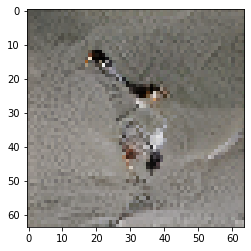

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 31

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.10910153388977 sec
Gen loss: 1.9841635521188339, Gen valid loss: 1.2208013620156906, Gen attr loss: 0.7635907771464608, Disc valid loss: 1.119018525127473, Disc valid real loss: 0.569300340685418, Disc valid fake loss: 0.5497181832305784, Disc attr loss: 1.8366423346162812, Disc attr real loss: 1.0730515574698203, Disc attr fake loss: 0.7635907771464608
Time for epoch 2 is 37.86895298957825 sec
Gen loss: 1.9727588940442093, Gen valid loss: 1.2043304684039378, Gen attr loss: 0.7686462526722007, Disc valid loss: 1.1185868057778212, Disc valid real loss: 0.5719765081476713, Disc valid fake loss: 0.5466102981955056, Disc attr loss: 1.8416231335986275, Disc attr real loss: 1.0729768809264268, Disc attr fake loss: 0.7686462526722007
Time for epoch 3 is 37.86473822593689 sec
Gen loss: 1.98797184955783, Gen valid loss: 1.222631843917092, Gen attr loss: 0.7

Time for epoch 23 is 38.12929821014404 sec
Gen loss: 1.9889568523339787, Gen valid loss: 1.2218097857020411, Gen attr loss: 0.767374265807754, Disc valid loss: 1.1149534300413881, Disc valid real loss: 0.5649514997877726, Disc valid fake loss: 0.5500019299305552, Disc attr loss: 1.839177467151063, Disc attr real loss: 1.071803201343309, Disc attr fake loss: 0.767374265807754
Time for epoch 24 is 38.10694146156311 sec
Gen loss: 1.985301889378204, Gen valid loss: 1.2163795339382761, Gen attr loss: 0.7691459500692724, Disc valid loss: 1.1120444568515147, Disc valid real loss: 0.567860893117703, Disc valid fake loss: 0.5441835627646304, Disc attr loss: 1.8410609222363004, Disc attr real loss: 1.071914972167028, Disc attr fake loss: 0.7691459500692724
Time for epoch 25 is 38.06268262863159 sec
Gen loss: 1.9956495526037241, Gen valid loss: 1.222567603678561, Gen attr loss: 0.7733065631331467, Disc valid loss: 1.1093726447281154, Disc valid real loss: 0.5664730882095451, Disc valid fake loss:

Time for epoch 45 is 38.126336336135864 sec
Gen loss: 1.9911144580944444, Gen valid loss: 1.2184057618544353, Gen attr loss: 0.7729314165063667, Disc valid loss: 1.1152605903827078, Disc valid real loss: 0.5688124290972867, Disc valid fake loss: 0.5464481616892466, Disc attr loss: 1.8431196593979833, Disc attr real loss: 1.0701882428916165, Disc attr fake loss: 0.7729314165063667
Time for epoch 46 is 38.09479808807373 sec
Gen loss: 1.9759118611896587, Gen valid loss: 1.2065750977534266, Gen attr loss: 0.7695552604954418, Disc valid loss: 1.120843364778896, Disc valid real loss: 0.5714385184007609, Disc valid fake loss: 0.5494048458127795, Disc attr loss: 1.839914660628249, Disc attr real loss: 1.0703594001328074, Disc attr fake loss: 0.7695552604954418
Time for epoch 47 is 38.08440113067627 sec
Gen loss: 1.9651147760349883, Gen valid loss: 1.2065452613481662, Gen attr loss: 0.7587933734180482, Disc valid loss: 1.1152274430928837, Disc valid real loss: 0.565816109257985, Disc valid fake

Time for epoch 67 is 38.01233530044556 sec
Gen loss: 1.9808637976323362, Gen valid loss: 1.2158278315694029, Gen attr loss: 0.7652612302684525, Disc valid loss: 1.1197494693241792, Disc valid real loss: 0.5734072655520142, Disc valid fake loss: 0.546342199087789, Disc attr loss: 1.8338612471492632, Disc attr real loss: 1.0686000168808107, Disc attr fake loss: 0.7652612302684525
Time for epoch 68 is 38.21841287612915 sec
Gen loss: 1.9969223944475334, Gen valid loss: 1.23389822906918, Gen attr loss: 0.7632594715935105, Disc valid loss: 1.1061914440416063, Disc valid real loss: 0.5628758189962485, Disc valid fake loss: 0.5433156241569416, Disc attr loss: 1.831691778449185, Disc attr real loss: 1.0684323068556747, Disc attr fake loss: 0.7632594715935105
Time for epoch 69 is 38.14081048965454 sec
Gen loss: 1.9826072916428894, Gen valid loss: 1.2165168772544965, Gen attr loss: 0.7663155036567026, Disc valid loss: 1.1158889566010577, Disc valid real loss: 0.5691557824611664, Disc valid fake l

Time for epoch 89 is 38.017385482788086 sec
Gen loss: 1.9920120546165196, Gen valid loss: 1.2197644004653785, Gen attr loss: 0.7724712849632511, Disc valid loss: 1.1114923039749063, Disc valid real loss: 0.5650461838658909, Disc valid fake loss: 0.5464461197859549, Disc attr loss: 1.840303256905822, Disc attr real loss: 1.0678319719425708, Disc attr fake loss: 0.7724712849632511
Time for epoch 90 is 37.971861839294434 sec
Gen loss: 1.9752114584775475, Gen valid loss: 1.2121845579082726, Gen attr loss: 0.7632513490472705, Disc valid loss: 1.1174298610467575, Disc valid real loss: 0.5679263374831295, Disc valid fake loss: 0.5495035234828628, Disc attr loss: 1.8302997203700264, Disc attr real loss: 1.0670483713227559, Disc attr fake loss: 0.7632513490472705
Time for epoch 91 is 37.98518490791321 sec
Gen loss: 1.981785763893024, Gen valid loss: 1.213646236635482, Gen attr loss: 0.7683621494750666, Disc valid loss: 1.1186095783057897, Disc valid real loss: 0.5734537222036501, Disc valid fak

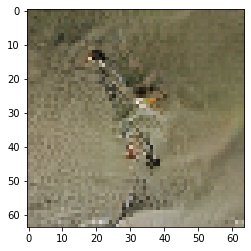

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 32

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 37.950923442840576 sec
Gen loss: 1.9722869567431731, Gen valid loss: 1.2089177450836512, Gen attr loss: 0.7635918593988186, Disc valid loss: 1.117210931248135, Disc valid real loss: 0.5704901190146521, Disc valid fake loss: 0.5467208103758856, Disc attr loss: 1.829993433099452, Disc attr real loss: 1.0664015737006334, Disc attr fake loss: 0.7635918593988186
Time for epoch 2 is 37.829878091812134 sec
Gen loss: 1.9949374538127, Gen valid loss: 1.229902021445556, Gen attr loss: 0.7652677313745183, Disc valid loss: 1.106005070170736, Disc valid real loss: 0.5636491935427596, Disc valid fake loss: 0.5423558759818555, Disc attr loss: 1.8314014600544442, Disc attr real loss: 1.0661337286799257, Disc attr fake loss: 0.7652677313745183
Time for epoch 3 is 38.149474143981934 sec
Gen loss: 1.9935316448289204, Gen valid loss: 1.2228067189374268, Gen attr loss: 0.

Time for epoch 23 is 37.94426894187927 sec
Gen loss: 1.9857503256500575, Gen valid loss: 1.2158514603689756, Gen attr loss: 0.7701217184867962, Disc valid loss: 1.1187836500364268, Disc valid real loss: 0.5694045203972639, Disc valid fake loss: 0.5493791286699817, Disc attr loss: 1.8355734902345715, Disc attr real loss: 1.0654517717477752, Disc attr fake loss: 0.7701217184867962
Time for epoch 24 is 37.77265787124634 sec
Gen loss: 1.9775831492612679, Gen valid loss: 1.2106979521632517, Gen attr loss: 0.767106982589091, Disc valid loss: 1.1119016492915994, Disc valid real loss: 0.5662273373707201, Disc valid fake loss: 0.5456743095786913, Disc attr loss: 1.8321976430693938, Disc attr real loss: 1.0650906604803028, Disc attr fake loss: 0.767106982589091
Time for epoch 25 is 37.85314989089966 sec
Gen loss: 1.9644999407171233, Gen valid loss: 1.1966057946365378, Gen attr loss: 0.7681083737350092, Disc valid loss: 1.1274996000899855, Disc valid real loss: 0.5779098083333272, Disc valid fake

Time for epoch 45 is 37.82889699935913 sec
Gen loss: 1.9779289298587375, Gen valid loss: 1.2128908207746056, Gen attr loss: 0.7652619030417466, Disc valid loss: 1.1123401685781917, Disc valid real loss: 0.5688291947208446, Disc valid fake loss: 0.543510975230354, Disc attr loss: 1.8291183978238403, Disc attr real loss: 1.0638564947820937, Disc attr fake loss: 0.7652619030417466
Time for epoch 46 is 37.855374574661255 sec
Gen loss: 1.9868272643102216, Gen valid loss: 1.2202078215475005, Gen attr loss: 0.7668461001662381, Disc valid loss: 1.115692293417809, Disc valid real loss: 0.5644194729282928, Disc valid fake loss: 0.551272818551154, Disc attr loss: 1.8305866656910759, Disc attr real loss: 1.0637405655248378, Disc attr fake loss: 0.7668461001662381
Time for epoch 47 is 37.8244104385376 sec
Gen loss: 1.986145502506556, Gen valid loss: 1.2159986911104301, Gen attr loss: 0.7703696129121754, Disc valid loss: 1.1132017897396553, Disc valid real loss: 0.5682536038118327, Disc valid fake l

Time for epoch 67 is 37.823768854141235 sec
Gen loss: 1.979762423329237, Gen valid loss: 1.2093722243619158, Gen attr loss: 0.7706095652205511, Disc valid loss: 1.1176887857235545, Disc valid real loss: 0.5716671766788979, Disc valid fake loss: 0.5460216065409383, Disc attr loss: 1.83339106584306, Disc attr real loss: 1.062781500622509, Disc attr fake loss: 0.7706095652205511
Time for epoch 68 is 37.850327253341675 sec
Gen loss: 1.978177237316845, Gen valid loss: 1.2100005606971782, Gen attr loss: 0.7683974604619551, Disc valid loss: 1.1216085423945088, Disc valid real loss: 0.5747529102696313, Disc valid fake loss: 0.5468556338209447, Disc attr loss: 1.8311547110397317, Disc attr real loss: 1.0627572505777767, Disc attr fake loss: 0.7683974604619551
Time for epoch 69 is 37.86953902244568 sec
Gen loss: 1.9765396544603797, Gen valid loss: 1.206349764574511, Gen attr loss: 0.7704078450112485, Disc valid loss: 1.1175188246135144, Disc valid real loss: 0.5708287136179968, Disc valid fake l

Time for epoch 89 is 37.755287647247314 sec
Gen loss: 1.9902700576678847, Gen valid loss: 1.2196981488527645, Gen attr loss: 0.7707963424323374, Disc valid loss: 1.112374822460216, Disc valid real loss: 0.5713337612992057, Disc valid fake loss: 0.5410410576881108, Disc attr loss: 1.8327433216539502, Disc attr real loss: 1.0619469792216127, Disc attr fake loss: 0.7707963424323374
Time for epoch 90 is 37.720377922058105 sec
Gen loss: 1.9881970191066505, Gen valid loss: 1.2278446414606359, Gen attr loss: 0.7605859928014802, Disc valid loss: 1.1025754972525081, Disc valid real loss: 0.5651089661328127, Disc valid fake loss: 0.5374665304735747, Disc attr loss: 1.822351940602145, Disc attr real loss: 1.0617659478006647, Disc attr fake loss: 0.7605859928014802
Time for epoch 91 is 37.78587102890015 sec
Gen loss: 1.9896138218360218, Gen valid loss: 1.2214050570800699, Gen attr loss: 0.7684352378535076, Disc valid loss: 1.1145886686759265, Disc valid real loss: 0.5703044854367005, Disc valid fa

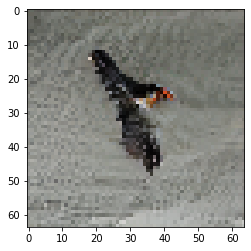

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 33

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 37.714927673339844 sec
Gen loss: 1.9773113462660048, Gen valid loss: 1.2119215432867447, Gen attr loss: 0.7656129406396612, Disc valid loss: 1.1241218434762825, Disc valid real loss: 0.5736713361772419, Disc valid fake loss: 0.5504505085912823, Disc attr loss: 1.8266316787983343, Disc attr real loss: 1.061018738158673, Disc attr fake loss: 0.7656129406396612
Time for epoch 2 is 37.714094161987305 sec
Gen loss: 1.9741720978806658, Gen valid loss: 1.2100707030877835, Gen attr loss: 0.764324257690409, Disc valid loss: 1.1167835762830285, Disc valid real loss: 0.5693005857267354, Disc valid fake loss: 0.5474829906370582, Disc attr loss: 1.8250964195101564, Disc attr real loss: 1.0607721618197474, Disc attr fake loss: 0.764324257690409
Time for epoch 3 is 37.807419300079346 sec
Gen loss: 1.963395530938456, Gen valid loss: 1.2045667504230488, Gen attr loss:

Time for epoch 23 is 37.75937247276306 sec
Gen loss: 1.9788784244196203, Gen valid loss: 1.210713645307029, Gen attr loss: 0.7683859241364125, Disc valid loss: 1.1233646231615124, Disc valid real loss: 0.5753261409800873, Disc valid fake loss: 0.5480384815353042, Disc attr loss: 1.8284504964422728, Disc attr real loss: 1.0600645723058602, Disc attr fake loss: 0.7683859241364125
Time for epoch 24 is 37.76394009590149 sec
Gen loss: 1.9700530563912741, Gen valid loss: 1.2084295925732227, Gen attr loss: 0.7618467395867758, Disc valid loss: 1.1166667007818454, Disc valid real loss: 0.5702760405333708, Disc valid fake loss: 0.5463906612176559, Disc attr loss: 1.821633186120651, Disc attr real loss: 1.059786446533875, Disc attr fake loss: 0.7618467395867758
Time for epoch 25 is 37.72802376747131 sec
Gen loss: 1.9775763837302602, Gen valid loss: 1.2097234848715102, Gen attr loss: 0.7680737040230252, Disc valid loss: 1.1154926853774363, Disc valid real loss: 0.5685780739719629, Disc valid fake 

Time for epoch 45 is 37.79443717002869 sec
Gen loss: 1.9785891797161361, Gen valid loss: 1.212303894483623, Gen attr loss: 0.7665081641215296, Disc valid loss: 1.115555100970798, Disc valid real loss: 0.569442435412549, Disc valid fake loss: 0.5461126654774839, Disc attr loss: 1.8248547738806664, Disc attr real loss: 1.058346609759137, Disc attr fake loss: 0.7665081641215296
Time for epoch 46 is 37.800272941589355 sec
Gen loss: 1.98883863322457, Gen valid loss: 1.2222936847991737, Gen attr loss: 0.7667726888889219, Disc valid loss: 1.1138885458956567, Disc valid real loss: 0.5660762476727246, Disc valid fake loss: 0.5478122964460999, Disc attr loss: 1.8250470620183763, Disc attr real loss: 1.0582743731294544, Disc attr fake loss: 0.7667726888889219
Time for epoch 47 is 37.600438356399536 sec
Gen loss: 1.992541049554096, Gen valid loss: 1.2204346831251935, Gen attr loss: 0.7723304026818211, Disc valid loss: 1.1147944001647514, Disc valid real loss: 0.5689187905975797, Disc valid fake lo

Time for epoch 67 is 37.53455400466919 sec
Gen loss: 1.9746425061368038, Gen valid loss: 1.211239747238676, Gen attr loss: 0.763626552532682, Disc valid loss: 1.123207303405131, Disc valid real loss: 0.5730027295548096, Disc valid fake loss: 0.5502045748195028, Disc attr loss: 1.8211139568145358, Disc attr real loss: 1.057487404281854, Disc attr fake loss: 0.763626552532682
Time for epoch 68 is 37.70030474662781 sec
Gen loss: 1.9840958134591742, Gen valid loss: 1.217815544385574, Gen attr loss: 0.7665059143288672, Disc valid loss: 1.1108348826728862, Disc valid real loss: 0.5658026440195275, Disc valid fake loss: 0.545032238088003, Disc attr loss: 1.82358399865427, Disc attr real loss: 1.0570780843254026, Disc attr fake loss: 0.7665059143288672
Time for epoch 69 is 37.62486457824707 sec
Gen loss: 1.987559243269406, Gen valid loss: 1.2164806994965407, Gen attr loss: 0.771301122861826, Disc valid loss: 1.1176489244308576, Disc valid real loss: 0.5718175276992766, Disc valid fake loss: 0.

Time for epoch 89 is 37.56555676460266 sec
Gen loss: 1.9803194159737771, Gen valid loss: 1.2130095070293603, Gen attr loss: 0.767532635187392, Disc valid loss: 1.1213173089311699, Disc valid real loss: 0.5726793577192921, Disc valid fake loss: 0.5486379535540655, Disc attr loss: 1.8238693067051854, Disc attr real loss: 1.0563366715177933, Disc attr fake loss: 0.767532635187392
Time for epoch 90 is 37.54674196243286 sec
Gen loss: 1.9728467092927555, Gen valid loss: 1.2060850521090232, Gen attr loss: 0.7669811951435679, Disc valid loss: 1.1154407652089913, Disc valid real loss: 0.5747030133477394, Disc valid fake loss: 0.5407377523458424, Disc attr loss: 1.8233764140909603, Disc attr real loss: 1.0563952189473924, Disc attr fake loss: 0.7669811951435679
Time for epoch 91 is 37.487364768981934 sec
Gen loss: 1.9710651193530901, Gen valid loss: 1.2057444509775013, Gen attr loss: 0.7655407495614959, Disc valid loss: 1.1239493773558598, Disc valid real loss: 0.5770214166906145, Disc valid fak

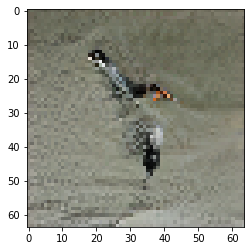

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 34

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 37.56338572502136 sec
Gen loss: 1.994293601855353, Gen valid loss: 1.221735248720743, Gen attr loss: 0.7727828114659483, Disc valid loss: 1.1161603144190821, Disc valid real loss: 0.5678846244081895, Disc valid fake loss: 0.5482756931607317, Disc attr loss: 1.8281890662705027, Disc attr real loss: 1.0554062548045544, Disc attr fake loss: 0.7727828114659483
Time for epoch 2 is 37.51895189285278 sec
Gen loss: 1.9849704869071318, Gen valid loss: 1.2168755699302445, Gen attr loss: 0.7683191766260762, Disc valid loss: 1.1160414865023398, Disc valid real loss: 0.5697442343241477, Disc valid fake loss: 0.5462972546011452, Disc attr loss: 1.8237903953244692, Disc attr real loss: 1.055471218698393, Disc attr fake loss: 0.7683191766260762
Time for epoch 3 is 37.61759328842163 sec
Gen loss: 1.963500619580752, Gen valid loss: 1.2020698553178368, Gen attr loss: 0.

Time for epoch 23 is 37.68477821350098 sec
Gen loss: 1.9774981175011737, Gen valid loss: 1.2138502649498504, Gen attr loss: 0.7638728250332965, Disc valid loss: 1.1167686962822911, Disc valid real loss: 0.5705449302506641, Disc valid fake loss: 0.5462237639317344, Disc attr loss: 1.8183008660145892, Disc attr real loss: 1.0544280409812927, Disc attr fake loss: 0.7638728250332965
Time for epoch 24 is 37.730186223983765 sec
Gen loss: 1.977713445983928, Gen valid loss: 1.2108992162112622, Gen attr loss: 0.7670361419034198, Disc valid loss: 1.1177898514561537, Disc valid real loss: 0.5663656900084115, Disc valid fake loss: 0.5514241585401984, Disc attr loss: 1.821740782357813, Disc attr real loss: 1.0547046404543932, Disc attr fake loss: 0.7670361419034198
Time for epoch 25 is 37.689876317977905 sec
Gen loss: 1.995737287087169, Gen valid loss: 1.226074837249146, Gen attr loss: 0.7698905253151891, Disc valid loss: 1.1081460756338062, Disc valid real loss: 0.5660100821557084, Disc valid fake

Time for epoch 45 is 37.603840589523315 sec
Gen loss: 1.97458265564306, Gen valid loss: 1.2064984263120304, Gen attr loss: 0.7683033080604987, Disc valid loss: 1.1186302079740902, Disc valid real loss: 0.5684421839429757, Disc valid fake loss: 0.5501880233849936, Disc attr loss: 1.8219805324303748, Disc attr real loss: 1.0536772243698762, Disc attr fake loss: 0.7683033080604987
Time for epoch 46 is 37.62066125869751 sec
Gen loss: 2.000479484315164, Gen valid loss: 1.232284146272716, Gen attr loss: 0.7684272527694702, Disc valid loss: 1.1100165819734094, Disc valid real loss: 0.5661312600946039, Disc valid fake loss: 0.543885320021208, Disc attr loss: 1.8218297068342606, Disc attr real loss: 1.0534024540647904, Disc attr fake loss: 0.7684272527694702
Time for epoch 47 is 37.84381461143494 sec
Gen loss: 1.986503296751317, Gen valid loss: 1.221141171326159, Gen attr loss: 0.76558988704914, Disc valid loss: 1.1135054271072553, Disc valid real loss: 0.570883526630841, Disc valid fake loss: 

Time for epoch 67 is 37.11368918418884 sec
Gen loss: 1.9902852208310673, Gen valid loss: 1.22702185393672, Gen attr loss: 0.7634951136299588, Disc valid loss: 1.11330936433177, Disc valid real loss: 0.5645867815508752, Disc valid fake loss: 0.5487225857692036, Disc attr loss: 1.8158226509081317, Disc attr real loss: 1.0523275372781729, Disc attr fake loss: 0.7634951136299588
Time for epoch 68 is 37.148231506347656 sec
Gen loss: 1.9753087258274316, Gen valid loss: 1.2154164991081569, Gen attr loss: 0.7601198557269605, Disc valid loss: 1.1145350401640584, Disc valid real loss: 0.5675583619896959, Disc valid fake loss: 0.5469766730861612, Disc attr loss: 1.8124778690699963, Disc attr real loss: 1.0523580133430357, Disc attr fake loss: 0.7601198557269605
Time for epoch 69 is 37.26484727859497 sec
Gen loss: 1.9894731774885803, Gen valid loss: 1.222215114247185, Gen attr loss: 0.7674854181323271, Disc valid loss: 1.1133479551894232, Disc valid real loss: 0.568554610983143, Disc valid fake lo

Time for epoch 89 is 36.9829535484314 sec
Gen loss: 1.9781676356385394, Gen valid loss: 1.2116078692400036, Gen attr loss: 0.7667821627968372, Disc valid loss: 1.1164597983605817, Disc valid real loss: 0.5723817286291096, Disc valid fake loss: 0.5440780687622908, Disc attr loss: 1.8180037954958475, Disc attr real loss: 1.0512216326990103, Disc attr fake loss: 0.7667821627968372
Time for epoch 90 is 37.01525068283081 sec
Gen loss: 1.9863170824722869, Gen valid loss: 1.2190121368664066, Gen attr loss: 0.7675306653265708, Disc valid loss: 1.112627693954199, Disc valid real loss: 0.568282213314439, Disc valid fake loss: 0.5443454760361494, Disc attr loss: 1.818860026555979, Disc attr real loss: 1.0513293612294081, Disc attr fake loss: 0.7675306653265708
Time for epoch 91 is 36.85974311828613 sec
Gen loss: 1.987009493962213, Gen valid loss: 1.2295114280085577, Gen attr loss: 0.7577339363938101, Disc valid loss: 1.114452513575877, Disc valid real loss: 0.5689254988661303, Disc valid fake los

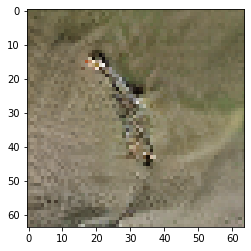

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 35

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 36.940152406692505 sec
Gen loss: 1.9865627418042522, Gen valid loss: 1.222688002961115, Gen attr loss: 0.7641040122282861, Disc valid loss: 1.1131402079651995, Disc valid real loss: 0.566492173568343, Disc valid fake loss: 0.5466480364967491, Disc attr loss: 1.8143329408756763, Disc attr real loss: 1.0502289286473903, Disc attr fake loss: 0.7641040122282861
Time for epoch 2 is 37.0834903717041 sec
Gen loss: 1.9850377086701432, Gen valid loss: 1.2222791315740362, Gen attr loss: 0.7629882074630034, Disc valid loss: 1.1078853918931026, Disc valid real loss: 0.5639623850180204, Disc valid fake loss: 0.5439230084903841, Disc attr loss: 1.8129889490158577, Disc attr real loss: 1.0500007415528543, Disc attr fake loss: 0.7629882074630034
Time for epoch 3 is 36.91205382347107 sec
Gen loss: 1.9695889655813614, Gen valid loss: 1.2055003565501392, Gen attr loss: 

Time for epoch 23 is 36.85328269004822 sec
Gen loss: 1.9787658007164313, Gen valid loss: 1.2181149797064825, Gen attr loss: 0.7608794193603805, Disc valid loss: 1.1190344448981246, Disc valid real loss: 0.5681299779634812, Disc valid fake loss: 0.5509044687922408, Disc attr loss: 1.8103394624663562, Disc attr real loss: 1.0494600431059757, Disc attr fake loss: 0.7608794193603805
Time for epoch 24 is 36.893988370895386 sec
Gen loss: 1.9863178245420379, Gen valid loss: 1.2251584479802347, Gen attr loss: 0.7613912491294427, Disc valid loss: 1.110377507804209, Disc valid real loss: 0.5676542019779444, Disc valid fake loss: 0.5427233038879022, Disc attr loss: 1.8106474170516822, Disc attr real loss: 1.0492561679222396, Disc attr fake loss: 0.7613912491294427
Time for epoch 25 is 36.88615107536316 sec
Gen loss: 1.9660885540773552, Gen valid loss: 1.2021762405630696, Gen attr loss: 0.7641313168091503, Disc valid loss: 1.121339391563643, Disc valid real loss: 0.5743602127402132, Disc valid fak

Time for epoch 45 is 36.77214980125427 sec
Gen loss: 1.9813726823827438, Gen valid loss: 1.2144641215562175, Gen attr loss: 0.7671322116683815, Disc valid loss: 1.1128565467147, Disc valid real loss: 0.565050050737412, Disc valid fake loss: 0.5478064984810062, Disc attr loss: 1.8159132997194927, Disc attr real loss: 1.048781088051111, Disc attr fake loss: 0.7671322116683815
Time for epoch 46 is 36.81029534339905 sec
Gen loss: 1.9610423967444153, Gen valid loss: 1.2033976389140617, Gen attr loss: 0.7578675039415437, Disc valid loss: 1.123695300846565, Disc valid real loss: 0.5723300786199286, Disc valid fake loss: 0.5513652226304621, Disc attr loss: 1.8062593420023518, Disc attr real loss: 1.0483918380608082, Disc attr fake loss: 0.7578675039415437
Time for epoch 47 is 36.787052631378174 sec
Gen loss: 1.9803197564794441, Gen valid loss: 1.2217864180968059, Gen attr loss: 0.7587648334541941, Disc valid loss: 1.111229996209545, Disc valid real loss: 0.5658333489726876, Disc valid fake los

Time for epoch 67 is 36.8135941028595 sec
Gen loss: 1.9701512816152598, Gen valid loss: 1.2011311876418467, Gen attr loss: 0.7692360288405483, Disc valid loss: 1.1191073505859064, Disc valid real loss: 0.5713024127289532, Disc valid fake loss: 0.5478049414106178, Disc attr loss: 1.817194338413435, Disc attr real loss: 1.0479583095728866, Disc attr fake loss: 0.7692360288405483
Time for epoch 68 is 36.7561891078949 sec
Gen loss: 1.9651199504934997, Gen valid loss: 1.2012032887476893, Gen attr loss: 0.7641351764118122, Disc valid loss: 1.127599047774545, Disc valid real loss: 0.5764995151903571, Disc valid fake loss: 0.5510995305650602, Disc attr loss: 1.8119998002439979, Disc attr real loss: 1.0478646238321858, Disc attr fake loss: 0.7641351764118122
Time for epoch 69 is 36.7603714466095 sec
Gen loss: 1.9783234625327877, Gen valid loss: 1.2154057641339495, Gen attr loss: 0.7631438116071024, Disc valid loss: 1.1138447691108475, Disc valid real loss: 0.5712884047490149, Disc valid fake lo

Time for epoch 89 is 36.72362446784973 sec
Gen loss: 1.9827749309177967, Gen valid loss: 1.2212551967884466, Gen attr loss: 0.7617494743367844, Disc valid loss: 1.11038752041535, Disc valid real loss: 0.5649242226670428, Disc valid fake loss: 0.5454633011404415, Disc attr loss: 1.8082322368453834, Disc attr real loss: 1.046482762508599, Disc attr fake loss: 0.7617494743367844
Time for epoch 90 is 36.85948657989502 sec
Gen loss: 1.9788716666420625, Gen valid loss: 1.218326871795706, Gen attr loss: 0.7607735556961721, Disc valid loss: 1.1186177032749827, Disc valid real loss: 0.5704982036012944, Disc valid fake loss: 0.5481194979776212, Disc attr loss: 1.8076489289924704, Disc attr real loss: 1.0468753732962983, Disc attr fake loss: 0.7607735556961721
Time for epoch 91 is 36.66263699531555 sec
Gen loss: 1.9816699893817022, Gen valid loss: 1.2097502402496856, Gen attr loss: 0.772138536784061, Disc valid loss: 1.1213432186987342, Disc valid real loss: 0.5740507157837472, Disc valid fake lo

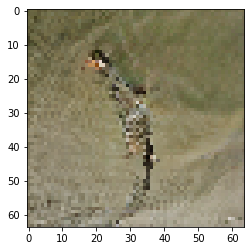

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 36

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 36.659104108810425 sec
Gen loss: 1.981724464796423, Gen valid loss: 1.2098297533304065, Gen attr loss: 0.772113547254061, Disc valid loss: 1.1219898318533652, Disc valid real loss: 0.5727793772207689, Disc valid fake loss: 0.5492104535018848, Disc attr loss: 1.8178722254305997, Disc attr real loss: 1.0457586781765387, Disc attr fake loss: 0.772113547254061
Time for epoch 2 is 36.9042387008667 sec
Gen loss: 1.9815851388584953, Gen valid loss: 1.2153831709045058, Gen attr loss: 0.7664264245084954, Disc valid loss: 1.1132778913024965, Disc valid real loss: 0.5706019136640761, Disc valid fake loss: 0.5426759728732794, Disc attr loss: 1.812376416795622, Disc attr real loss: 1.0459499922871267, Disc attr fake loss: 0.7664264245084954
Time for epoch 3 is 36.72360706329346 sec
Gen loss: 1.968967934611044, Gen valid loss: 1.2075378424753018, Gen attr loss: 0.7

Time for epoch 23 is 36.640212059020996 sec
Gen loss: 1.9886678253732077, Gen valid loss: 1.223283686935094, Gen attr loss: 0.7656129614770574, Disc valid loss: 1.1147807988370984, Disc valid real loss: 0.5687821295849353, Disc valid fake loss: 0.5459986670715052, Disc attr loss: 1.810689762032775, Disc attr real loss: 1.0450768005557176, Disc attr fake loss: 0.7656129614770574
Time for epoch 24 is 36.63746738433838 sec
Gen loss: 1.9928184120958736, Gen valid loss: 1.2296332492414852, Gen attr loss: 0.7634182459293666, Disc valid loss: 1.101709607009319, Disc valid real loss: 0.5611134198138384, Disc valid fake loss: 0.5405961867916552, Disc attr loss: 1.808962511014809, Disc attr real loss: 1.0455442650854425, Disc attr fake loss: 0.7634182459293666
Time for epoch 25 is 36.62781524658203 sec
Gen loss: 1.98161159879793, Gen valid loss: 1.2112058257345908, Gen attr loss: 0.770626047116308, Disc valid loss: 1.1187579709339917, Disc valid real loss: 0.5723512666981395, Disc valid fake los

Time for epoch 45 is 36.68918204307556 sec
Gen loss: 1.982121012398221, Gen valid loss: 1.2167517323157975, Gen attr loss: 0.7655948402112739, Disc valid loss: 1.1114309675648284, Disc valid real loss: 0.5679794500675305, Disc valid fake loss: 0.5434515174165327, Disc attr loss: 1.8096979775725988, Disc attr real loss: 1.044103137361325, Disc attr fake loss: 0.7655948402112739
Time for epoch 46 is 36.647794246673584 sec
Gen loss: 1.9841866667677717, Gen valid loss: 1.2172688861203387, Gen attr loss: 0.7671428225873932, Disc valid loss: 1.1214977388136431, Disc valid real loss: 0.5748097365949212, Disc valid fake loss: 0.5466880029456079, Disc attr loss: 1.8115493731123968, Disc attr real loss: 1.0444065505250038, Disc attr fake loss: 0.7671428225873932
Time for epoch 47 is 36.637494802474976 sec
Gen loss: 1.9834312517145463, Gen valid loss: 1.2175975273941269, Gen attr loss: 0.7660594711781841, Disc valid loss: 1.1121678714183612, Disc valid real loss: 0.5647456636273764, Disc valid fa

Time for epoch 67 is 36.59672689437866 sec
Gen loss: 1.973217645957864, Gen valid loss: 1.2043490698990138, Gen attr loss: 0.7690861914862139, Disc valid loss: 1.1200442764817216, Disc valid real loss: 0.5712698364483955, Disc valid fake loss: 0.548774440840977, Disc attr loss: 1.8123043599490551, Disc attr real loss: 1.0432181684628412, Disc attr fake loss: 0.7690861914862139
Time for epoch 68 is 36.666571378707886 sec
Gen loss: 1.9722544371597166, Gen valid loss: 1.202349536302613, Gen attr loss: 0.7701209979005622, Disc valid loss: 1.1235035748339604, Disc valid real loss: 0.5723348994888264, Disc valid fake loss: 0.5511686770412011, Disc attr loss: 1.813384177562021, Disc attr real loss: 1.0432631796614587, Disc attr fake loss: 0.7701209979005622
Time for epoch 69 is 36.624958515167236 sec
Gen loss: 1.9943881386986917, Gen valid loss: 1.2321268699679595, Gen attr loss: 0.7624960627336166, Disc valid loss: 1.1059582936085337, Disc valid real loss: 0.5640050264070351, Disc valid fake

Time for epoch 89 is 36.657400369644165 sec
Gen loss: 1.9892328657755038, Gen valid loss: 1.2226911279244153, Gen attr loss: 0.7667696858809246, Disc valid loss: 1.109486381858991, Disc valid real loss: 0.566549592144121, Disc valid fake loss: 0.542936788099568, Disc attr loss: 1.8090464883057407, Disc attr real loss: 1.042276802424816, Disc attr fake loss: 0.7667696858809246
Time for epoch 90 is 36.63931083679199 sec
Gen loss: 1.9730835122467703, Gen valid loss: 1.2138813876201144, Gen attr loss: 0.7594293343019356, Disc valid loss: 1.1172716974565977, Disc valid real loss: 0.5701177637105389, Disc valid fake loss: 0.5471539343114145, Disc attr loss: 1.8016949300843526, Disc attr real loss: 1.042265595782417, Disc attr fake loss: 0.7594293343019356
Time for epoch 91 is 36.663880348205566 sec
Gen loss: 1.965440226118093, Gen valid loss: 1.200689823969916, Gen attr loss: 0.7649682429101732, Disc valid loss: 1.129708032136364, Disc valid real loss: 0.574564705453914, Disc valid fake loss

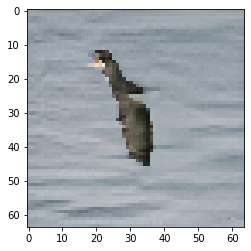

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 37

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 36.68901324272156 sec
Gen loss: 1.9700427914699565, Gen valid loss: 1.2102938006886945, Gen attr loss: 0.7599741338391292, Disc valid loss: 1.1214973702017208, Disc valid real loss: 0.572180391004092, Disc valid fake loss: 0.5493169829935886, Disc attr loss: 1.8018957657542656, Disc attr real loss: 1.0419216319151363, Disc attr fake loss: 0.7599741338391292
Time for epoch 2 is 36.65096187591553 sec
Gen loss: 1.967873175938924, Gen valid loss: 1.2048312189779307, Gen attr loss: 0.763262721904248, Disc valid loss: 1.1188145250808903, Disc valid real loss: 0.5694863730006747, Disc valid fake loss: 0.5493281532916919, Disc attr loss: 1.805033893119998, Disc attr real loss: 1.04177117121575, Disc attr fake loss: 0.763262721904248
Time for epoch 3 is 36.683955907821655 sec
Gen loss: 1.9727850603217354, Gen valid loss: 1.2086464413782445, Gen attr loss: 0.76

Time for epoch 23 is 36.67171621322632 sec
Gen loss: 1.9777937177720109, Gen valid loss: 1.2122104688065485, Gen attr loss: 0.7658064373463473, Disc valid loss: 1.1226956017295195, Disc valid real loss: 0.5715680993023281, Disc valid fake loss: 0.5511275072730977, Disc attr loss: 1.8065159931415464, Disc attr real loss: 1.040709555795199, Disc attr fake loss: 0.7658064373463473
Time for epoch 24 is 36.65157675743103 sec
Gen loss: 1.9620022431298647, Gen valid loss: 1.1975118168970433, Gen attr loss: 0.7647068151613561, Disc valid loss: 1.125547956483474, Disc valid real loss: 0.5702320085308417, Disc valid fake loss: 0.5553159490833438, Disc attr loss: 1.8053492737333303, Disc attr real loss: 1.0406424585719742, Disc attr fake loss: 0.7647068151613561
Time for epoch 25 is 36.609517335891724 sec
Gen loss: 1.9725754548540606, Gen valid loss: 1.2040039409143815, Gen attr loss: 0.7687891023914989, Disc valid loss: 1.1135314022945517, Disc valid real loss: 0.567882561829032, Disc valid fake

Time for epoch 45 is 36.58834743499756 sec
Gen loss: 1.9760320790737949, Gen valid loss: 1.2150148591051904, Gen attr loss: 0.7612440855845526, Disc valid loss: 1.1136570731152686, Disc valid real loss: 0.5677683504454811, Disc valid fake loss: 0.5458887240427942, Disc attr loss: 1.8011148988716001, Disc attr real loss: 1.0398708132870476, Disc attr fake loss: 0.7612440855845526
Time for epoch 46 is 36.59291982650757 sec
Gen loss: 1.9846144617411503, Gen valid loss: 1.2091861166928195, Gen attr loss: 0.7756450993581839, Disc valid loss: 1.1180992840428339, Disc valid real loss: 0.570446114229962, Disc valid fake loss: 0.5476531701359323, Disc attr loss: 1.8153481840441221, Disc attr real loss: 1.039703084685938, Disc attr fake loss: 0.7756450993581839
Time for epoch 47 is 36.62241506576538 sec
Gen loss: 1.9764053695570163, Gen valid loss: 1.2106544519181497, Gen attr loss: 0.7659732457098922, Disc valid loss: 1.1225384488338377, Disc valid real loss: 0.5749077313153078, Disc valid fake

Time for epoch 67 is 36.60507607460022 sec
Gen loss: 1.976267760039022, Gen valid loss: 1.2138905221530738, Gen attr loss: 0.7626028603654567, Disc valid loss: 1.1163274464891533, Disc valid real loss: 0.5687600240959385, Disc valid fake loss: 0.547567424977698, Disc attr loss: 1.801495997401757, Disc attr real loss: 1.0388931370363004, Disc attr fake loss: 0.7626028603654567
Time for epoch 68 is 36.633910179138184 sec
Gen loss: 1.977629337530472, Gen valid loss: 1.2071757796334057, Gen attr loss: 0.7706717905313342, Disc valid loss: 1.122509591786196, Disc valid real loss: 0.5729865735462365, Disc valid fake loss: 0.5495230187245501, Disc attr loss: 1.8094905509858275, Disc attr real loss: 1.0388187604544932, Disc attr fake loss: 0.7706717905313342
Time for epoch 69 is 36.6062273979187 sec
Gen loss: 1.9887883792401653, Gen valid loss: 1.2203293174585998, Gen attr loss: 0.7686848648518405, Disc valid loss: 1.1131490565897004, Disc valid real loss: 0.5708276352423639, Disc valid fake lo

Time for epoch 89 is 36.53644585609436 sec
Gen loss: 1.9792973504156923, Gen valid loss: 1.2143547069735643, Gen attr loss: 0.7651672195289839, Disc valid loss: 1.1177916011513087, Disc valid real loss: 0.5679634126221261, Disc valid fake loss: 0.5498281878830618, Disc attr loss: 1.8029266435925553, Disc attr real loss: 1.0377594240635715, Disc attr fake loss: 0.7651672195289839
Time for epoch 90 is 36.61431384086609 sec
Gen loss: 1.9728576513486826, Gen valid loss: 1.2066984977825548, Gen attr loss: 0.7663792966181023, Disc valid loss: 1.115385936366187, Disc valid real loss: 0.5705959418924843, Disc valid fake loss: 0.5447899926161055, Disc attr loss: 1.8043085099235783, Disc attr real loss: 1.0379292133054758, Disc attr fake loss: 0.7663792966181023
Time for epoch 91 is 36.521716594696045 sec
Gen loss: 1.9879881460169144, Gen valid loss: 1.2200404344212394, Gen attr loss: 0.7681736348444207, Disc valid loss: 1.1166103895763717, Disc valid real loss: 0.568556869175376, Disc valid fak

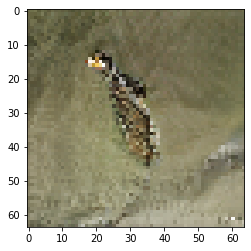

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 38

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 36.59170699119568 sec
Gen loss: 1.9842469214100824, Gen valid loss: 1.2251156725211518, Gen attr loss: 0.7593641069523365, Disc valid loss: 1.1136680754219614, Disc valid real loss: 0.5650980806124566, Disc valid fake loss: 0.5485699961825115, Disc attr loss: 1.7961134996194503, Disc attr real loss: 1.0367493926671139, Disc attr fake loss: 0.7593641069523365
Time for epoch 2 is 36.54991173744202 sec
Gen loss: 1.9764671189998224, Gen valid loss: 1.2135281328586383, Gen attr loss: 0.7631641514902192, Disc valid loss: 1.1176326610854648, Disc valid real loss: 0.5691347498557755, Disc valid fake loss: 0.5484979097759174, Disc attr loss: 1.79984903109429, Disc attr real loss: 1.0366848796040709, Disc attr fake loss: 0.7631641514902192
Time for epoch 3 is 36.51989984512329 sec
Gen loss: 1.985553668766487, Gen valid loss: 1.2184297839800518, Gen attr loss: 0

Time for epoch 23 is 36.48453187942505 sec
Gen loss: 1.983674724250628, Gen valid loss: 1.224137077486612, Gen attr loss: 0.759769808309188, Disc valid loss: 1.1143086673767586, Disc valid real loss: 0.5673119822330268, Disc valid fake loss: 0.5469966842553157, Disc attr loss: 1.79558304267201, Disc attr real loss: 1.035813234362822, Disc attr fake loss: 0.759769808309188
Time for epoch 24 is 36.4650719165802 sec
Gen loss: 1.9844433498899465, Gen valid loss: 1.2158100052577694, Gen attr loss: 0.7688568122987824, Disc valid loss: 1.1131316964542317, Disc valid real loss: 0.5702581439560991, Disc valid fake loss: 0.5428735501559446, Disc attr loss: 1.80443068523071, Disc attr real loss: 1.0355738729319275, Disc attr fake loss: 0.7688568122987824
Time for epoch 25 is 36.508052825927734 sec
Gen loss: 1.9878329574900269, Gen valid loss: 1.2177178428425053, Gen attr loss: 0.7703387893958467, Disc valid loss: 1.116999482559318, Disc valid real loss: 0.5731492439098151, Disc valid fake loss: 0

Time for epoch 45 is 36.505924701690674 sec
Gen loss: 1.9812471766458941, Gen valid loss: 1.2128534598079155, Gen attr loss: 0.7686158194128414, Disc valid loss: 1.1113252508931044, Disc valid real loss: 0.567678979338023, Disc valid fake loss: 0.543646272928088, Disc attr loss: 1.8037020476852976, Disc attr real loss: 1.0350862282724562, Disc attr fake loss: 0.7686158194128414
Time for epoch 46 is 36.48541593551636 sec
Gen loss: 1.9831523220067424, Gen valid loss: 1.2159167027408837, Gen attr loss: 0.7674598411169802, Disc valid loss: 1.1235290791607162, Disc valid real loss: 0.575058616677597, Disc valid fake loss: 0.5484704620792937, Disc attr loss: 1.8025989918527887, Disc attr real loss: 1.0351391507358085, Disc attr fake loss: 0.7674598411169802
Time for epoch 47 is 36.4849693775177 sec
Gen loss: 1.9632466437047735, Gen valid loss: 1.200831287275485, Gen attr loss: 0.7626344382278318, Disc valid loss: 1.126048568303023, Disc valid real loss: 0.5768863907674464, Disc valid fake lo

Time for epoch 67 is 36.43658947944641 sec
Gen loss: 1.9822316043745212, Gen valid loss: 1.217042296559507, Gen attr loss: 0.7654151091084571, Disc valid loss: 1.1103575312025178, Disc valid real loss: 0.5642240870451216, Disc valid fake loss: 0.5461334427036244, Disc attr loss: 1.8001543380380647, Disc attr real loss: 1.0347392289296076, Disc attr fake loss: 0.7654151091084571
Time for epoch 68 is 36.47929573059082 sec
Gen loss: 1.9817860326792813, Gen valid loss: 1.2132470572220924, Gen attr loss: 0.7687612028948982, Disc valid loss: 1.121813476893314, Disc valid real loss: 0.5690500205609856, Disc valid fake loss: 0.5527634549593214, Disc attr loss: 1.8031358728563882, Disc attr real loss: 1.03437466996149, Disc attr fake loss: 0.7687612028948982
Time for epoch 69 is 36.454317808151245 sec
Gen loss: 1.9809125435707693, Gen valid loss: 1.216447782064195, Gen attr loss: 0.7646906228892525, Disc valid loss: 1.1160446027430093, Disc valid real loss: 0.5667968587823676, Disc valid fake l

Time for epoch 89 is 36.44739270210266 sec
Gen loss: 1.9823266141782931, Gen valid loss: 1.2178688373992113, Gen attr loss: 0.7646843532559672, Disc valid loss: 1.1161963413078286, Disc valid real loss: 0.5729901810002521, Disc valid fake loss: 0.5432061600652813, Disc attr loss: 1.798675104369962, Disc attr real loss: 1.033990751113995, Disc attr fake loss: 0.7646843532559672
Time for epoch 90 is 36.450132608413696 sec
Gen loss: 1.9755787271148144, Gen valid loss: 1.2142148051804644, Gen attr loss: 0.7615902192870453, Disc valid loss: 1.1150814399809694, Disc valid real loss: 0.5680842804230326, Disc valid fake loss: 0.5469971571349839, Disc attr loss: 1.7957062000827737, Disc attr real loss: 1.0341159807957285, Disc attr fake loss: 0.7615902192870453
Time for epoch 91 is 36.47240424156189 sec
Gen loss: 1.997336583408883, Gen valid loss: 1.2288262078432532, Gen attr loss: 0.7687404028122341, Disc valid loss: 1.1111364477695165, Disc valid real loss: 0.5630719480798819, Disc valid fake

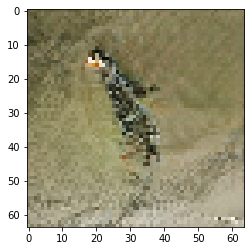

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 39

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 36.45525074005127 sec
Gen loss: 1.9795106494329808, Gen valid loss: 1.2174296555157276, Gen attr loss: 0.7623085452289116, Disc valid loss: 1.1240601906285377, Disc valid real loss: 0.5740201177635813, Disc valid fake loss: 0.5500400741571979, Disc attr loss: 1.7960889723888904, Disc attr real loss: 1.0337804271599789, Disc attr fake loss: 0.7623085452289116
Time for epoch 2 is 36.45945930480957 sec
Gen loss: 1.9895376794060395, Gen valid loss: 1.226374104094053, Gen attr loss: 0.7633950508383878, Disc valid loss: 1.103703167218826, Disc valid real loss: 0.5622376549211621, Disc valid fake loss: 0.5414655135899056, Disc attr loss: 1.7972321689613466, Disc attr real loss: 1.0338371181229589, Disc attr fake loss: 0.7633950508383878
Time for epoch 3 is 36.3651967048645 sec
Gen loss: 1.9753878093993438, Gen valid loss: 1.212862949868851, Gen attr loss: 0.

Time for epoch 23 is 36.37780261039734 sec
Gen loss: 1.9788006631339468, Gen valid loss: 1.219752131600367, Gen attr loss: 0.7592787579469241, Disc valid loss: 1.120205959168876, Disc valid real loss: 0.5753729459716053, Disc valid fake loss: 0.544833011743499, Disc attr loss: 1.7922682529542504, Disc attr real loss: 1.0329894950073264, Disc attr fake loss: 0.7592787579469241
Time for epoch 24 is 36.426963567733765 sec
Gen loss: 2.0016481401474495, Gen valid loss: 1.2337049152146833, Gen attr loss: 0.768175972994104, Disc valid loss: 1.1029789830611003, Disc valid real loss: 0.5606471477808345, Disc valid fake loss: 0.5423318341495545, Disc attr loss: 1.8013177840367243, Disc attr real loss: 1.0331418110426203, Disc attr fake loss: 0.768175972994104
Time for epoch 25 is 36.39414715766907 sec
Gen loss: 1.970966134937152, Gen valid loss: 1.2160178949516318, Gen attr loss: 0.7551786431129063, Disc valid loss: 1.1234876915691345, Disc valid real loss: 0.5724382311671083, Disc valid fake lo

Time for epoch 45 is 36.37887501716614 sec
Gen loss: 1.9738675162075012, Gen valid loss: 1.2142517518221847, Gen attr loss: 0.7598429520924886, Disc valid loss: 1.1191299019790277, Disc valid real loss: 0.5713909064851156, Disc valid fake loss: 0.5477389958169725, Disc attr loss: 1.79216644482884, Disc attr real loss: 1.0323234927363512, Disc attr fake loss: 0.7598429520924886
Time for epoch 46 is 36.379289388656616 sec
Gen loss: 1.980255783734929, Gen valid loss: 1.2190210396035255, Gen attr loss: 0.7614635046581589, Disc valid loss: 1.1175815551907713, Disc valid real loss: 0.5712766106212689, Disc valid fake loss: 0.5463049470732205, Disc attr loss: 1.7935109440550248, Disc attr real loss: 1.032047439396866, Disc attr fake loss: 0.7614635046581589
Time for epoch 47 is 36.4458441734314 sec
Gen loss: 1.9850082504070872, Gen valid loss: 1.2162162020277525, Gen attr loss: 0.7690156331553368, Disc valid loss: 1.1129959393646012, Disc valid real loss: 0.569000983060537, Disc valid fake lo

Time for epoch 67 is 36.41090369224548 sec
Gen loss: 1.984736394752978, Gen valid loss: 1.2193085107053845, Gen attr loss: 0.7656546932895009, Disc valid loss: 1.1120270295194816, Disc valid real loss: 0.5668779147995843, Disc valid fake loss: 0.5451491177889712, Disc attr loss: 1.7971894736212444, Disc attr real loss: 1.0315347803317434, Disc attr fake loss: 0.7656546932895009
Time for epoch 68 is 36.40494132041931 sec
Gen loss: 1.9845146906731252, Gen valid loss: 1.2222568341063935, Gen attr loss: 0.7624877289058717, Disc valid loss: 1.1146793514086302, Disc valid real loss: 0.5673230550476529, Disc valid fake loss: 0.5473562936149639, Disc attr loss: 1.7941812712971756, Disc attr real loss: 1.031693542391304, Disc attr fake loss: 0.7624877289058717
Time for epoch 69 is 36.37904119491577 sec
Gen loss: 1.9912751473708528, Gen valid loss: 1.227003874979045, Gen attr loss: 0.7645025051383145, Disc valid loss: 1.1132782736444862, Disc valid real loss: 0.569893032150863, Disc valid fake l

Time for epoch 89 is 36.37011742591858 sec
Gen loss: 1.9771834440670686, Gen valid loss: 1.2173058065941664, Gen attr loss: 0.7601062178934815, Disc valid loss: 1.113947838948671, Disc valid real loss: 0.5684752707397388, Disc valid fake loss: 0.545472567239751, Disc attr loss: 1.7910786868757025, Disc attr real loss: 1.030972468982221, Disc attr fake loss: 0.7601062178934815
Time for epoch 90 is 36.402998208999634 sec
Gen loss: 1.9892972307153511, Gen valid loss: 1.2302876861114813, Gen attr loss: 0.7592450507934178, Disc valid loss: 1.1085860803521423, Disc valid real loss: 0.5668598408621501, Disc valid fake loss: 0.541726242639831, Disc attr loss: 1.7902153244186547, Disc attr real loss: 1.0309702736252369, Disc attr fake loss: 0.7592450507934178
Time for epoch 91 is 36.3838791847229 sec
Gen loss: 1.9898213432410221, Gen valid loss: 1.2282574624226992, Gen attr loss: 0.7617970957019464, Disc valid loss: 1.1160400081779251, Disc valid real loss: 0.5694050427859392, Disc valid fake l

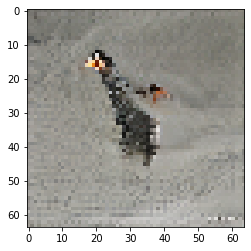

In [458]:
next_starting_checkpoint, totalepochs, warmup = long_train(starting_checkpoint=next_starting_checkpoint, 
                                      num_checkpoints=20, 
                                      checkpoint_interval=100, 
                                      g_hist=gen_loss_hist, 
                                      g_valid_hist=gen_valid_loss_hist,
                                      g_attr_hist=gen_attr_loss_hist,
                                      d_hist=disc_loss_hist,
                                      d_real_hist=disc_loss_real_hist,
                                      d_fake_hist=disc_loss_fake_hist,
                                      d_attr_real_hist=disc_attr_loss_real_hist,
                                      d_attr_fake_hist=disc_attr_loss_fake_hist,
                                      noise=noise300,
                                      attr=attr,
                                      save_files=True,
                                      warmup=warmup)

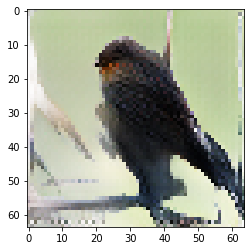

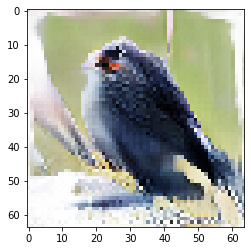

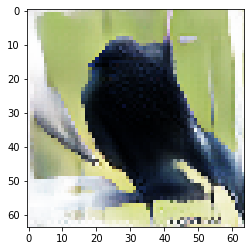

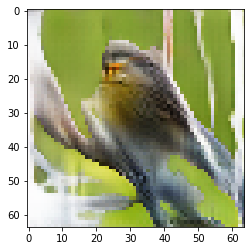

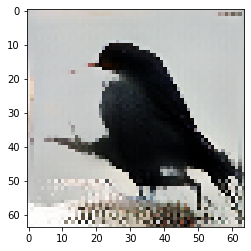

In [590]:
attrs = train_attrs[np.random.choice(range(len(train_attrs)), 5, replace=False)]
# attrs = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
# tempnoise = np.random.normal(0, 1, 300)
for i in range(5):
#     tempnoise = np.random.normal(0, 1, 300)

    
#     attrs[2] += 1.
    
    generated_image = generator.predict([np.array([tempnoise]), np.array([4. * attrs[i]])] )[0]
    plt.imshow(unnormalize_img(generated_image))
    plt.show()
#     ax.imshow(unnormalize_img(generated_image))

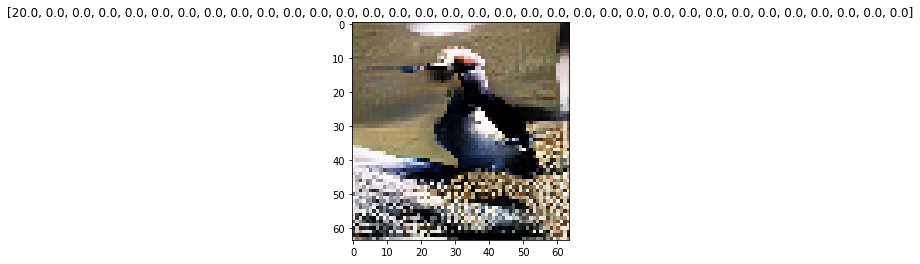

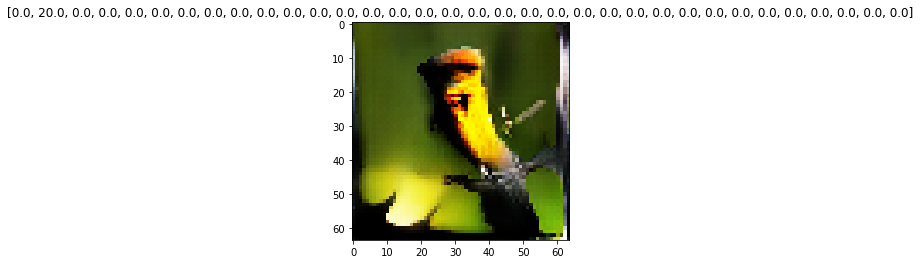

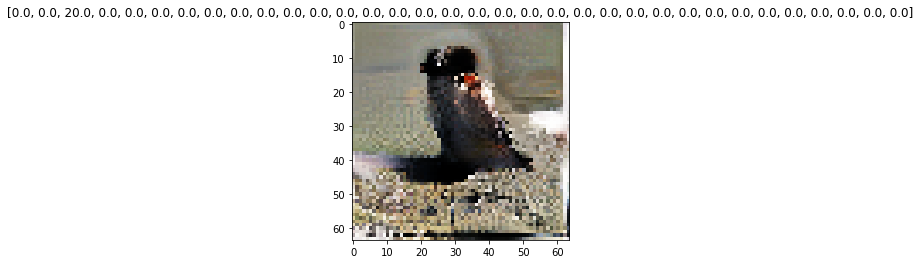

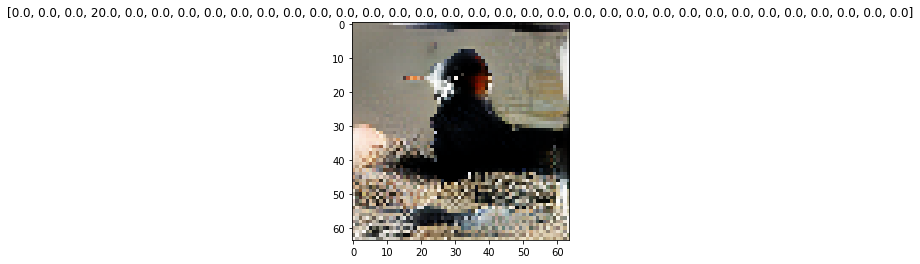

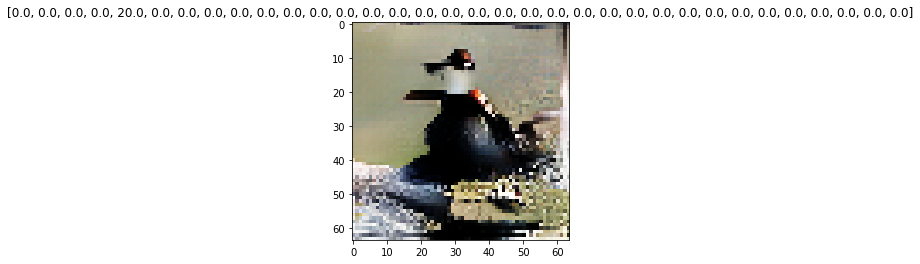

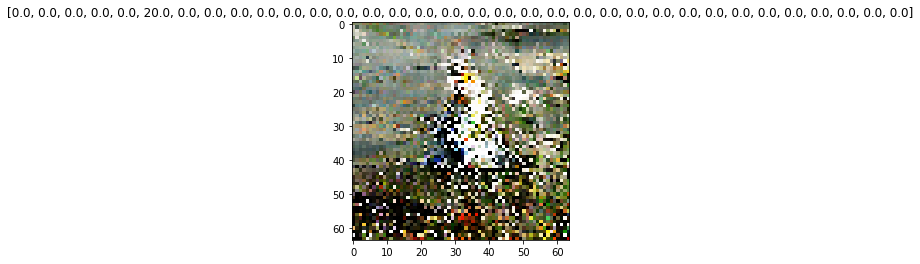

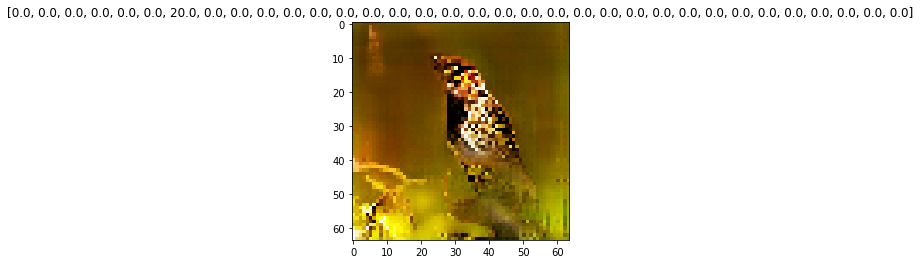

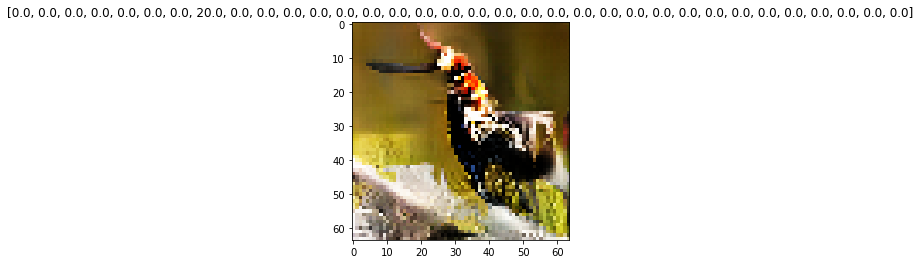

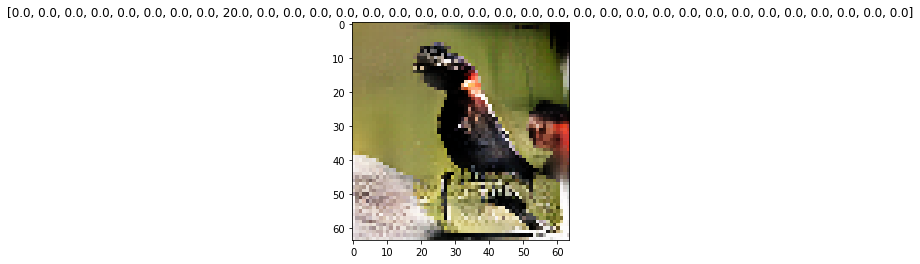

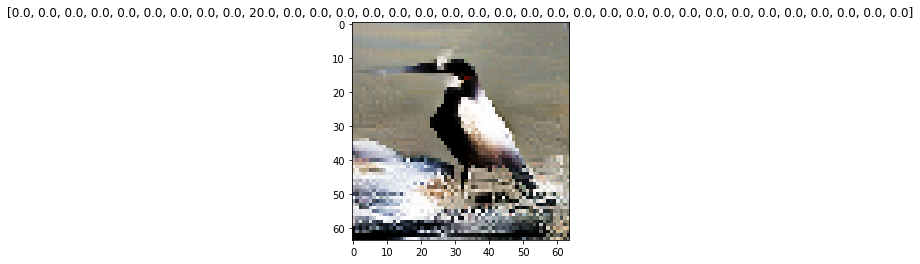

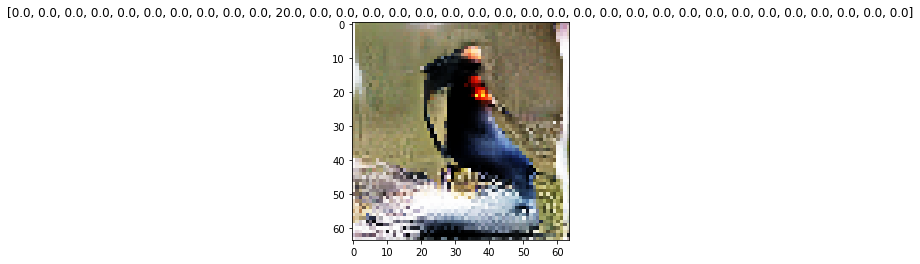

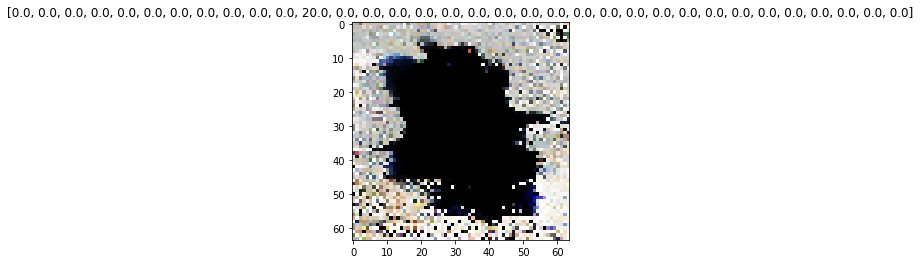

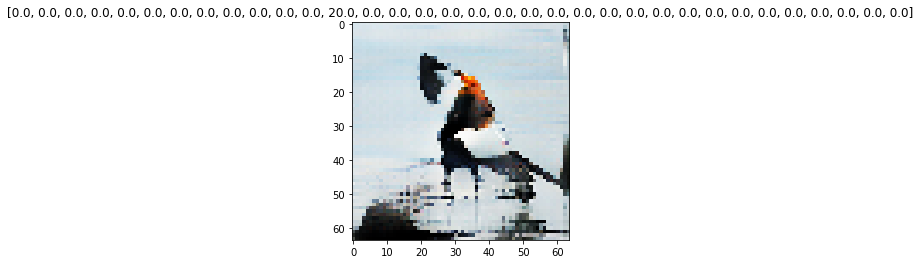

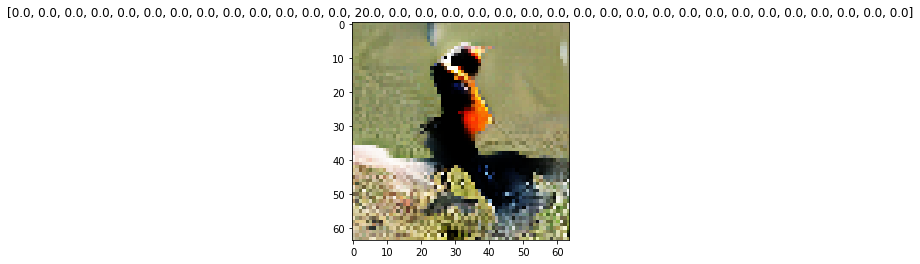

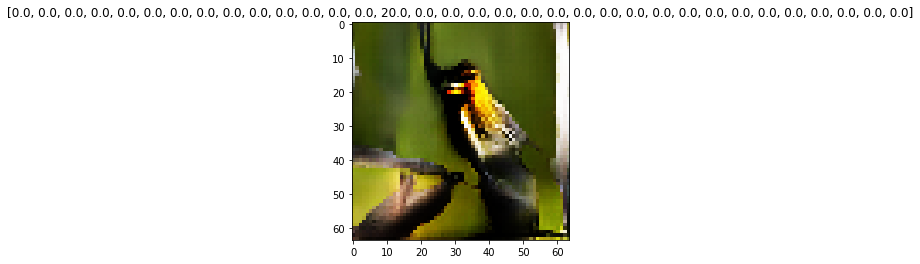

In [556]:
# noise = np.random.normal(0, 1, 300)
for i in range(15):
    attrs = [0. for _ in range(34)]
#     attrs = np.round(np.random.uniform(0, 1, 10)) * 3
#     attrs[5] -= 1
    attrs[i] += 20
    generated_image = generator.predict([np.array([tempnoise]), np.array([attrs])] )[0]
    plt.imshow(unnormalize_img(generated_image))
    plt.title(str(attrs))
    plt.show()
#     ax.imshow(unnormalize_img(generated_image))

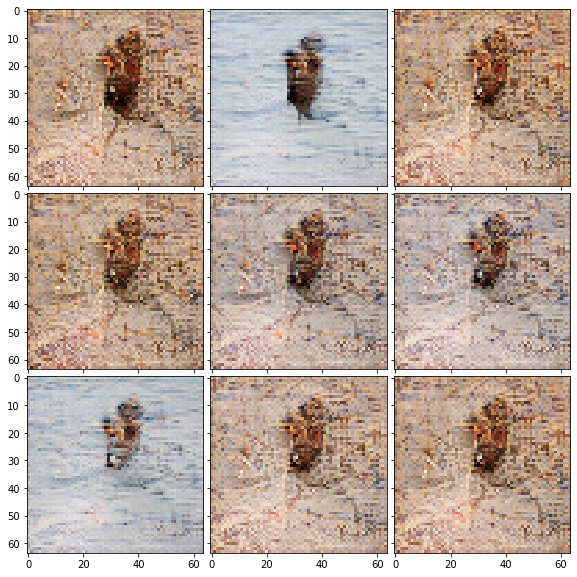

In [153]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

attrs = train_attrs[np.random.choice(range(len(train_attrs)), 9, replace=False)]
tempnoise = np.random.normal(0, 1, 300)
for i, ax in enumerate(grid):
    generated_image = generator.predict([np.array([tempnoise]), np.array([attrs[i]])] )[0]
    ax.imshow(unnormalize_img(generated_image))

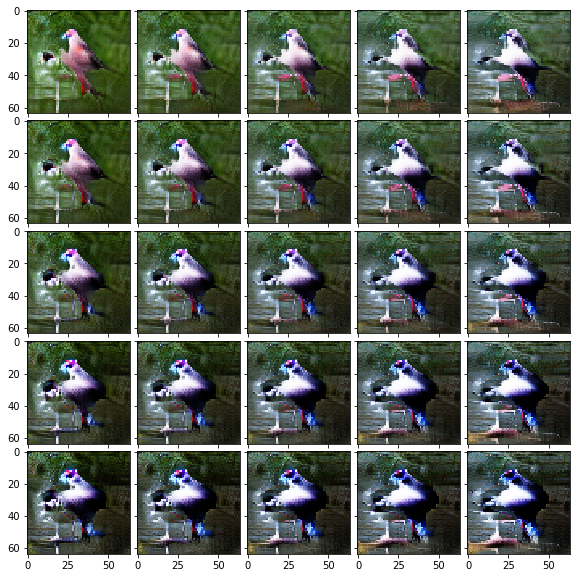

In [457]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),
                 axes_pad=0.1,  # pad between axes in inch.
                 )
attrs[20:] = 0.
for i, ax in enumerate(grid):
#     attrs = [0. for _ in range(34)]
    x = i % 5
    y = (i // 5) % 5
    attrs[21] = (3.*x)
    attrs[27] = (3.*y)
    generated_image = generator.predict([np.array([tempnoise]), np.array([attrs])] )[0]
    ax.imshow(unnormalize_img(generated_image))

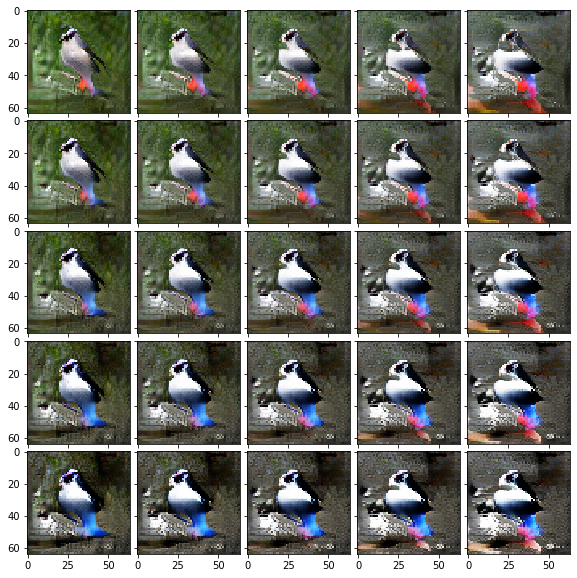

In [460]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),
                 axes_pad=0.1,  # pad between axes in inch.
                 )
attrs[20:] = 0.
for i, ax in enumerate(grid):
#     attrs = [0. for _ in range(34)]
    x = i % 5
    y = (i // 5) % 5
    attrs[21] = (3.*x)
    attrs[27] = (3.*y)
    generated_image = generator.predict([np.array([tempnoise]), np.array([attrs])] )[0]
    ax.imshow(unnormalize_img(generated_image))

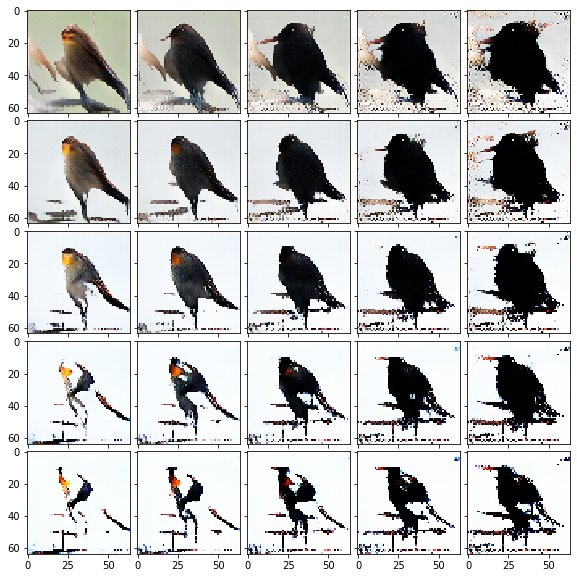

In [599]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),
                 axes_pad=0.1,  # pad between axes in inch.
                 )

attrs = train_attrs[np.random.choice(range(len(train_attrs)), 9, replace=False)]
for i, ax in enumerate(grid):
    attrs = [0. for _ in range(34)]
    x = i % 5
    y = (i // 5) % 5
    attrs[11] = (4*x)
    attrs[12] = (10*y)
    generated_image = generator.predict([np.array([tempnoise]), np.array([attrs])] )[0]
    ax.imshow(unnormalize_img(generated_image))

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),
                 axes_pad=0.1,  # pad between axes in inch.
                 )

attrs = train_attrs[np.random.choice(range(len(train_attrs)), 9, replace=False)]
for i, ax in enumerate(grid):
    attrs = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
    x = i % 5
    y = (i // 5) % 5
    attrs[2] = (x)
    attrs[4] = (y)
    generated_image = generator.predict([np.array([tempnoise]), np.array([attrs])] )[0]
    ax.imshow(unnormalize_img(generated_image))

In [ ]:
savednoise = tempnoise.copy()
# tempnoise = savednoise.copy()

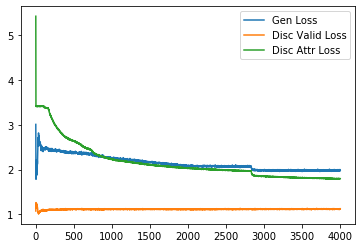

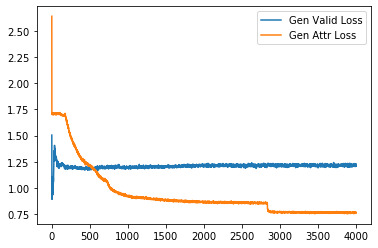

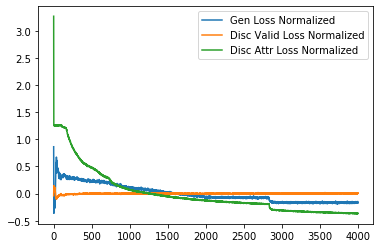

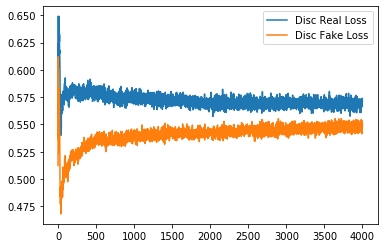

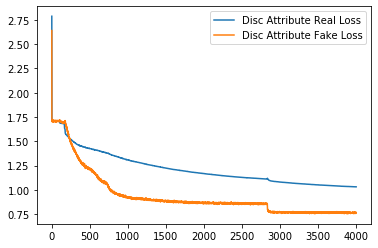

In [459]:
plot_save_dir = 'bird-gan-attributes-split-sigmoid-simple-tuning-34vector'

from operator import add
disc_attr_loss_hist = list( map(add, disc_attr_loss_real_hist, disc_attr_loss_fake_hist) )

plt.plot(gen_loss_hist)
plt.plot(disc_loss_hist)
plt.plot(disc_attr_loss_hist)

plt.legend(['Gen Loss','Disc Valid Loss', 'Disc Attr Loss'])
plt.savefig('./results/plots/'+plot_save_dir+'/g_d_losses.png')
plt.show()

plt.plot(gen_valid_loss_hist)
plt.plot(gen_attr_loss_hist)
plt.legend(['Gen Valid Loss', 'Gen Attr Loss'])
plt.savefig('./results/plots/'+plot_save_dir+'/g_valid_attr_losses.png')
plt.show()

plt.plot(gen_loss_hist - np.mean(gen_loss_hist))
plt.plot(disc_loss_hist - np.mean(disc_loss_hist))
plt.plot(disc_attr_loss_hist - np.mean(disc_attr_loss_hist))
plt.legend(['Gen Loss Normalized','Disc Valid Loss Normalized', 'Disc Attr Loss Normalized'])
plt.savefig('./results/plots/'+plot_save_dir+'/g_d_losses_normalized.png')
plt.show()

plt.plot(disc_loss_real_hist)
plt.plot(disc_loss_fake_hist)
plt.legend(['Disc Real Loss','Disc Fake Loss'])
plt.savefig('./results/plots/'+plot_save_dir+'/d_real_fake_losses.png')
plt.show()

plt.plot(disc_attr_loss_real_hist)
# plt.show()
plt.plot(disc_attr_loss_fake_hist)
plt.legend(['Disc Attribute Real Loss', 'Disc Attribute Fake Loss'])
plt.savefig('./results/plots/'+plot_save_dir+'/d_attribute_real_fake_losses.png')
plt.show()


In [611]:
prediction = discriminator_attr.predict(np.array([train_imgs[6]]))[0]
print(np.where(np.round(prediction) == 1))

(array([11, 18], dtype=int64),)


In [610]:
prediction = discriminator_attr.predict(np.array([train_imgs[344]]))[0]
print(np.where(np.round(prediction) == 1))

(array([ 5, 18], dtype=int64),)


In [653]:
d = dict.fromkeys([i for i in range(34)], 0)
prediction = discriminator_attr.predict(np.array(train_imgs))
prediction = np.round(prediction)
for p in prediction:
    p = np.where(p == 1)
    for i in p[0]:
        d[i] += 1
    
# for im in train_imgs:
#     for p in prediction[0]:
#         d[p] += 1

<BarContainer object of 34 artists>

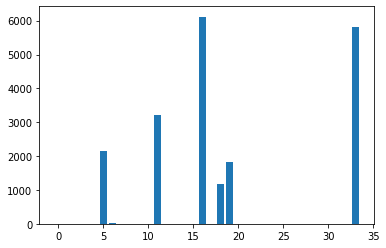

In [659]:
plt.bar([x for x in range(34)], d.values())

<BarContainer object of 34 artists>

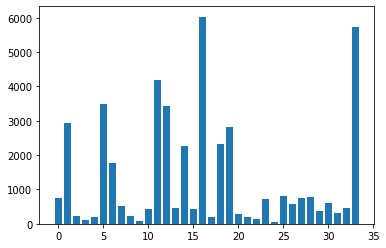

In [660]:
plt.bar([x for x in range(34)], np.sum(train_attrs, axis=0))

In [661]:
d.values()

dict_values([0, 0, 0, 0, 0, 2150, 9, 0, 0, 0, 0, 3215, 0, 0, 3, 0, 6116, 0, 1190, 1837, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 5817])